### Importamos ciertas librerias necesarias para realizar scraping con respecto a los productos en la RD que se encuentran en el dataset de Open Food Facts

In [1]:
import requests
import pandas as pd
import os
import time

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("openfoodfacts/world-food-facts")

print("Path to dataset files:", path)

100%|██████████| 109M/109M [00:16<00:00, 6.77MB/s] 

Extracting files...


Path to dataset files: /home/friasluna/.cache/kagglehub/datasets/openfoodfacts/world-food-facts/versions/5


In [ ]:
import pandas as pd
import os
import requests

# Ruta al archivo TSV
file_path = '/home/friasluna/.cache/kagglehub/datasets/openfoodfacts/world-food-facts/versions/5/en.openfoodfacts.org.products.tsv'

# Leer el archivo TSV con pandas
df = pd.read_csv(file_path, sep='\t', low_memory=False)

# Obtener todas las categorías únicas
df['categories'] = df['categories'].str.split(',')  # Dividir las categorías por comas
df = df.explode('categories')  # Expandir las listas de categorías en filas separadas
df['categories'] = df['categories'].str.strip()  # Eliminar espacios en blanco
unique_categories = df['categories'].dropna().unique()  # Obtener categorías únicas y eliminar NaN

# Crear una carpeta para cada categoría y descargar las imágenes
for category in unique_categories:
    # Filtrar productos por categoría
    category_df = df[df['categories'] == category]
    
    # Crear carpeta para la categoría
    category_folder = f"openfoodfacts_dataset/{category}"
    os.makedirs(category_folder, exist_ok=True)
    
    # Descargar las imágenes
    image_count = 0  # Contador de imágenes descargadas
    for _, product in category_df.iterrows():
        image_url = product.get('image_url')
        if image_url:
            # Nombre del archivo de imagen
            image_filename = f"{category_folder}/{image_count}.jpg"
            
            # Verificar si la imagen ya existe
            if not os.path.exists(image_filename):
                try:
                    img_data = requests.get(image_url).content
                    with open(image_filename, "wb") as img_file:
                        img_file.write(img_data)
                    # print(f"Descargada imagen {image_count + 1} para la categoría {category}")
                    image_count += 1
                except Exception as e:
                    print(f"Error al descargar imagen: {e}")
            

print("¡Descarga completa!")

Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar imagen: Inv

In [2]:
import os
import shutil
from pathlib import Path
import random
from typing import List, Dict, Set
import yaml
from ultralytics import YOLO

def setup_training_folders(base_path: Path):
    """Crear estructura de directorios para entrenamiento."""
    # Usar la ruta completa
    base_dir = base_path / 'yolo_dataset'
    
    # Crear directorios necesarios
    dirs = ['images/train', 'images/val', 'labels/train', 'labels/val']
    for dir_path in dirs:
        (base_dir / dir_path).mkdir(parents=True, exist_ok=True)
    
    return base_dir

def get_acopio_categories() -> Dict[str, str]:
    """Mapear categorías del dataset a nuestras categorías de interés."""
    return {
        'Conserves': 'canned_food',
        'Biscuits': 'cookies',
        'Céréales et dérivés': 'cereals',
        'Produits laitiers': 'dairy',
        'Boissons': 'beverages'
    }

def prepare_dataset(source_dir: Path, dest_dir: Path, train_split: float = 0.8):
    """Preparar dataset para entrenamiento YOLO."""
    categories = get_acopio_categories()
    category_list = list(categories.values())
    
    # Crear archivo data.yaml con rutas absolutas
    data_yaml = {
        'train': str(dest_dir / 'images/train'),
        'val': str(dest_dir / 'images/val'),
        'nc': len(categories),
        'names': category_list
    }
    
    yaml_path = dest_dir / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.safe_dump(data_yaml, f, sort_keys=False)
    
    print(f"Archivo data.yaml creado en: {yaml_path}")
    print("Contenido del data.yaml:")
    print(data_yaml)

    for src_category, target_category in categories.items():
        src_path = source_dir / src_category
        if not src_path.exists():
            print(f"Advertencia: No se encontró el directorio {src_path}")
            continue

        print(f"Procesando categoría: {src_category} desde {src_path}")
        
        # Obtener todas las imágenes
        images = list(src_path.glob('*.jpg')) + list(src_path.glob('*.jpeg')) + list(src_path.glob('*.png'))
        if not images:
            print(f"No se encontraron imágenes en {src_path}")
            continue
            
        print(f"Encontradas {len(images)} imágenes para {src_category}")
        
        random.shuffle(images)
        
        # Dividir en train y val
        split_idx = int(len(images) * train_split)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Copiar imágenes y crear etiquetas
        for img_list, subset in [(train_images, 'train'), (val_images, 'val')]:
            for img_path in img_list:
                # Copiar imagen
                dest_img_path = dest_dir / f'images/{subset}' / img_path.name
                shutil.copy2(img_path, dest_img_path)
                print(f"Copiada imagen a {dest_img_path}")
                
                # Crear archivo de etiquetas YOLO
                label_path = dest_dir / f'labels/{subset}' / f'{img_path.stem}.txt'
                create_yolo_label(label_path, category_list.index(target_category))

def create_yolo_label(label_path: Path, class_id: int):
    """Crear archivo de etiquetas YOLO."""
    with open(label_path, 'w') as f:
        f.write(f'{class_id} 0.5 0.5 1.0 1.0\n')



In [5]:
if __name__ == '__main__':
    # Usar rutas absolutas
    base_directory = Path('/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook')
    source_directory = base_directory / 'openfoodfacts_dataset'
    
    print(f"Directorio fuente: {source_directory}")
    if not source_directory.exists():
        raise FileNotFoundError(f"No se encontró el directorio fuente: {source_directory}")
    
    # Crear estructura de directorios
    yolo_directory = setup_training_folders(base_directory)
    print(f"Directorio YOLO creado en: {yolo_directory}")
    
    # Preparar dataset
    prepare_dataset(source_directory, yolo_directory)
    
    # Entrenar modelo
    model = YOLO('yolov8n.pt')
    
    # Entrenar modelo usando ruta absoluta al archivo yaml
    yaml_path = str(yolo_directory / 'data.yaml')
    print(f"Iniciando entrenamiento con archivo de configuración: {yaml_path}")
    
    results = model.train(
        data=yaml_path,
        epochs=100,
        imgsz=640,
        batch=16,
        patience=20,
        name='acopio_model'
    )

Directorio fuente: /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/openfoodfacts_dataset
Directorio YOLO creado en: /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset
Archivo data.yaml creado en: /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/data.yaml
Contenido del data.yaml:
{'train': '/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/train', 'val': '/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/val', 'nc': 5, 'names': ['canned_food', 'cookies', 'cereals', 'dairy', 'beverages']}
Procesando categoría: Conserves desde /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/openfoodfacts_dataset/Conserves
Encontradas 1991 imágenes para Conserves
Copiada imagen a /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/train/1441.jpg
Copiada imagen a /home/friasluna/Tesis_Proyect/proy

train: Scanning /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/labels/train... 4414 images, 0 backgrounds, 74 corrupt: 100%|██████████| 4488/4488 [00:03<00:00, 1465.01it/s]

train: WARNING ⚠️ /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/train/1474.jpg: ignoring corrupt image/label: cannot identify image file '/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/train/1474.jpg'
train: WARNING ⚠️ /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/train/2652.jpg: ignoring corrupt image/label: cannot identify image file '/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/train/2652.jpg'
train: WARNING ⚠️ /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/train/2823.jpg: ignoring corrupt image/label: cannot identify image file '/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/train/2823.jpg'
train: WARNING ⚠️ /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/train/2909.jpg: ignoring corrupt image/lab

train: New cache created: /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/labels/val... 4005 images, 0 backgrounds, 37 corrupt: 100%|██████████| 4042/4042 [00:03<00:00, 1220.15it/s]

val: WARNING ⚠️ /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/val/1528.jpg: ignoring corrupt image/label: cannot identify image file '/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/val/1528.jpg'
val: WARNING ⚠️ /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/val/1942.jpg: ignoring corrupt image/label: cannot identify image file '/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/val/1942.jpg'
val: WARNING ⚠️ /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/val/3159.jpg: ignoring corrupt image/label: cannot identify image file '/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/val/3159.jpg'
val: WARNING ⚠️ /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/images/val/3520.jpg: ignoring corrupt image/label: cannot identify im

val: New cache created: /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/yolo_dataset/labels/val.cache
Plotting labels to runs/detect/acopio_model3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/acopio_model3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.39G     0.2595      1.401     0.9621         50        640: 100%|██████████| 276/276 [03:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]


                   all       4005       4005      0.784      0.316      0.342      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.41G     0.1888     0.7637     0.9064         41        640: 100%|██████████| 276/276 [03:53<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.18it/s]


                   all       4005       4005      0.783      0.328      0.327      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.4G     0.1879     0.6631     0.9002         47        640: 100%|██████████| 276/276 [03:54<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:55<00:00,  2.26it/s]

                   all       4005       4005      0.726      0.347      0.318      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.38G     0.1678     0.5964     0.8924         41        640: 100%|██████████| 276/276 [03:54<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.793      0.329      0.379      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.38G     0.1521     0.5492     0.8903         46        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.797      0.343      0.443      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.38G     0.1374     0.5385     0.8819         46        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.843      0.315      0.375       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.38G     0.1291     0.5142     0.8804         44        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.816      0.321      0.358      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.38G     0.1304     0.5184     0.8781         47        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.825      0.327      0.403      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.38G     0.1246     0.4892     0.8723         42        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.804      0.341      0.377      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.38G     0.1204     0.4838     0.8745         48        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.839      0.317      0.406      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.38G     0.1136     0.4724     0.8744         46        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.806      0.327      0.404      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.38G     0.1086      0.469      0.872         39        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.25it/s]

                   all       4005       4005      0.747      0.396      0.429      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.38G     0.1077     0.4691     0.8735         45        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.832      0.321      0.422      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.38G     0.1021     0.4517     0.8713         42        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.772      0.386      0.429      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.38G     0.1005     0.4401     0.8723         47        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.851      0.335      0.398      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.38G     0.0979     0.4415     0.8684         36        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.161      0.883      0.448      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.38G    0.09264     0.4489      0.865         45        640: 100%|██████████| 276/276 [03:54<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.565      0.471      0.461      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.38G    0.09155     0.4253     0.8662         38        640: 100%|██████████| 276/276 [03:54<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.629      0.373      0.423      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.38G    0.09056     0.4129     0.8633         46        640: 100%|██████████| 276/276 [03:54<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.568      0.405      0.397       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.38G    0.08637      0.414     0.8632         44        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.198      0.752      0.452      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.38G    0.08839     0.4177     0.8624         47        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.576      0.449      0.445      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.38G    0.08801     0.4135     0.8656         38        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.696      0.418       0.41      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.38G    0.08459     0.4017     0.8622         41        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.592      0.413      0.468      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.38G    0.08407     0.3998     0.8653         45        640: 100%|██████████| 276/276 [03:54<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.175      0.881      0.423      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.38G    0.08394     0.3894     0.8623         48        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.484      0.601      0.468      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.38G    0.08254     0.3854     0.8632         45        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.557      0.454      0.445       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.38G    0.08226     0.3891     0.8667         44        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.519      0.563       0.47      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.38G    0.07845     0.3899     0.8615         47        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.25it/s]

                   all       4005       4005      0.577      0.524      0.479      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.38G    0.07476      0.381     0.8609         49        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.605      0.446      0.447      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.38G    0.07692     0.3725     0.8603         45        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.632      0.446       0.47      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.38G    0.07497     0.3561      0.863         40        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.25it/s]

                   all       4005       4005      0.624      0.434       0.45      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.38G    0.07231     0.3615     0.8611         46        640: 100%|██████████| 276/276 [04:03<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [01:01<00:00,  2.04it/s]

                   all       4005       4005      0.578      0.503       0.49      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.38G        inf     0.3672     0.8602         41        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.608      0.469      0.497      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.38G    0.07345      0.363     0.8616         46        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.595      0.492      0.493      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.38G    0.07279     0.3456     0.8652         39        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.21it/s]

                   all       4005       4005      0.612      0.489      0.492       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.38G    0.07155     0.3395     0.8617         50        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.25it/s]

                   all       4005       4005      0.581      0.533      0.506      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.38G    0.06988     0.3407     0.8616         49        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.21it/s]

                   all       4005       4005      0.606      0.503      0.509      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.38G     0.0694     0.3357     0.8574         46        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.612      0.497      0.506      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.38G     0.0652     0.3372     0.8571         42        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.604      0.483      0.482       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.38G    0.06668     0.3261     0.8605         45        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.629      0.459      0.467      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.38G    0.06825     0.3232     0.8611         46        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.646      0.434      0.458      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.38G    0.06512     0.3183     0.8594         48        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.632      0.501      0.512      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.38G    0.06322     0.3227     0.8562         47        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.21it/s]

                   all       4005       4005       0.62      0.529      0.543      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.38G    0.06339     0.3161     0.8565         43        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.607      0.539      0.528      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.38G    0.06205     0.3207     0.8587         50        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.609      0.528      0.534      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.38G    0.06145     0.3106      0.859         44        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.661      0.506       0.54      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.38G    0.06052     0.2977     0.8535         49        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.616      0.538      0.537      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.38G    0.06245     0.3061     0.8588         50        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.611      0.523      0.529      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.38G    0.05975     0.2994     0.8577         43        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.635      0.542      0.561       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.38G    0.05897      0.292     0.8579         48        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.19it/s]

                   all       4005       4005      0.642      0.551      0.562      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G    0.05712     0.2877     0.8605         42        640: 100%|██████████| 276/276 [03:59<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.19it/s]

                   all       4005       4005      0.657      0.522      0.556      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.38G     0.0574     0.2828     0.8565         50        640: 100%|██████████| 276/276 [04:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.19it/s]

                   all       4005       4005      0.669      0.539      0.567      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.38G     0.0578     0.2838     0.8567         45        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.678      0.513      0.529      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.38G    0.05674     0.2885     0.8575         46        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.655      0.508      0.537      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.38G    0.05727     0.2739      0.858         43        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.659      0.557       0.57      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.38G    0.05707     0.2795     0.8553         45        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.653       0.56      0.557      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.38G    0.05741     0.2635     0.8558         42        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.20it/s]

                   all       4005       4005       0.69      0.535      0.559      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.38G    0.05737     0.2637     0.8576         46        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.704      0.511      0.557      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.38G    0.05306     0.2571      0.856         45        640: 100%|██████████| 276/276 [03:59<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.651      0.548      0.554      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.38G    0.05451     0.2601     0.8576         45        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.691      0.547      0.579      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.38G    0.05405      0.261     0.8582         46        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.688      0.535      0.573      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.38G     0.0527      0.255     0.8557         48        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.711      0.557      0.581      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.38G    0.05085     0.2472     0.8548         49        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.662      0.558      0.573      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.38G    0.05033     0.2477     0.8594         36        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.664      0.548       0.57      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.38G    0.05119     0.2456     0.8566         46        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.21it/s]

                   all       4005       4005      0.662      0.558       0.57      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.38G    0.05073     0.2447     0.8549         45        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.19it/s]

                   all       4005       4005      0.717      0.502      0.554      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.38G    0.05054     0.2408     0.8544         43        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.707      0.524      0.567      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.38G    0.05074     0.2474     0.8558         50        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.691      0.532      0.567      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.38G    0.04969     0.2364     0.8547         47        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.19it/s]

                   all       4005       4005      0.737      0.518      0.585      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.38G    0.05018     0.2446     0.8551         45        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.664      0.549      0.575      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.38G    0.04971     0.2392     0.8554         48        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.707      0.537      0.577      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.38G     0.0469     0.2228     0.8572         50        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.19it/s]

                   all       4005       4005      0.664      0.564      0.583      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.38G    0.04632     0.2323     0.8552         34        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.25it/s]

                   all       4005       4005      0.683      0.548      0.572      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.38G    0.04546     0.2236     0.8559         48        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.21it/s]

                   all       4005       4005      0.673      0.523      0.552      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.38G    0.04593     0.2202     0.8562         40        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.665      0.557      0.568      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.38G    0.04464     0.2168     0.8525         43        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.686      0.532      0.565      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.38G    0.04341     0.2145     0.8552         48        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.714      0.537      0.583       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.38G    0.04314     0.2107     0.8564         49        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.699       0.54      0.572      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.38G     0.0436      0.217     0.8528         48        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.704      0.544      0.587      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.38G    0.04259     0.2094     0.8527         42        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.21it/s]

                   all       4005       4005      0.738      0.511      0.569      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.38G    0.04349     0.2034     0.8546         45        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.699      0.545       0.58      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.38G     0.0411     0.2054     0.8535         47        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.734      0.508      0.572      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.38G    0.03943     0.1958     0.8511         43        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.696      0.521      0.566      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.38G    0.03887     0.1951     0.8555         40        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.20it/s]

                   all       4005       4005      0.744      0.516      0.572      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.38G    0.03951     0.1995     0.8537         43        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.718       0.52       0.57      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.38G    0.04066     0.1883     0.8539         42        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.701       0.54      0.564      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.38G    0.03869     0.1926     0.8558         47        640: 100%|██████████| 276/276 [03:57<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.20it/s]

                   all       4005       4005      0.679      0.541      0.561       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.38G    0.03838     0.1892      0.855         47        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.20it/s]

                   all       4005       4005       0.45      0.562      0.566      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.38G     0.0379     0.1868     0.8548         51        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.20it/s]

                   all       4005       4005      0.724      0.532      0.572      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.38G    0.03835     0.1867     0.8545         48        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.21it/s]

                   all       4005       4005      0.724      0.523      0.567      0.563


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.38G    0.04995     0.1549     0.8526         14        640: 100%|██████████| 276/276 [03:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.636      0.552      0.537      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.38G    0.03666     0.1134     0.8371         14        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.695      0.528      0.557      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.38G     0.0363     0.1037     0.8456         14        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.21it/s]

                   all       4005       4005      0.682      0.563      0.571       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.38G    0.03399     0.1009     0.8379         14        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.25it/s]

                   all       4005       4005       0.73      0.518      0.566      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.38G    0.03379    0.09322       0.84         14        640: 100%|██████████| 276/276 [03:56<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.21it/s]

                   all       4005       4005      0.679      0.546       0.56      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.38G    0.03281    0.08721     0.8378         14        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.705      0.555      0.577      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.38G    0.03078    0.08498     0.8384         14        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]

                   all       4005       4005      0.692      0.544      0.562      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.38G    0.03094    0.07982     0.8384         14        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.22it/s]

                   all       4005       4005      0.708      0.532      0.565      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.38G    0.02974     0.0746     0.8339         14        640: 100%|██████████| 276/276 [03:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:56<00:00,  2.24it/s]

                   all       4005       4005      0.678      0.563      0.566      0.566
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 79, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



99 epochs completed in 8.088 hours.
Optimizer stripped from runs/detect/acopio_model3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/acopio_model3/weights/best.pt, 6.2MB

Validating runs/detect/acopio_model3/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1050, 4039MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:57<00:00,  2.20it/s]


                   all       4005       4005      0.704      0.544      0.587      0.585
           canned_food        273        273          1          0     0.0923     0.0923
               cookies        404        404      0.631      0.399      0.564      0.558
               cereals        356        356      0.572      0.461      0.512      0.512
                 dairy       1229       1229      0.648      0.867      0.839      0.838
             beverages       1743       1743      0.671      0.992      0.927      0.927
Speed: 0.3ms preprocess, 10.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/acopio_model3


In [11]:
from ultralytics import YOLO
from PIL import Image
import torch

# Cargar el modelo entrenado
model = YOLO('runs/detect/acopio_model3/weights/best.pt')

# Ruta a tu imagen de prueba
image_path = 'ej4.jpeg'  # Reemplaza esto con la ruta a tu imagen

# Realizar la predicción
results = model.predict(image_path, conf=0.25)  # conf es el umbral de confianza

# Visualizar resultados
results[0].show()  # Esto mostrará la imagen con las detecciones


image 1/1 /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/ej4.jpeg: 640x512 1 dairy, 1 beverages, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


In [1]:
import tensorflow as tf

# Deshabilitar la GPU
tf.config.set_visible_devices([], 'GPU')

# Verificar que la GPU esté deshabilitada
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-01-30 21:07:01.644353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738285621.697301    5666 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738285621.712826    5666 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 21:07:01.842769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


In [1]:
import os
import tensorflow as tf

# Deshabilitar la GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Verificar que la GPU esté deshabilitada
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-01-30 19:33:10.458740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738279990.474796   19046 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738279990.479979   19046 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 19:33:10.497245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


2025-01-30 19:33:12.653115: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-30 19:33:12.653144: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: friasluna
2025-01-30 19:33:12.653151: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: friasluna
2025-01-30 19:33:12.653235: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.183.1
2025-01-30 19:33:12.653256: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2025-01-30 19:33:12.653262: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.183.1


### Instalamos ciertas librerias que seran utilizadas para el analisis del modelo, como ademas, el manejo de los datos.

In [11]:
pip install scikit-learn seaborn matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.6/913.6 kB 4.8 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 7.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 7.6 MB/s eta 0:00:008.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install transformers torch pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 7.7 MB/s eta 0:00:007.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [48]:
!pip install tensorflow tensorflow-hub

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 5.2 MB/s eta 0:00:00m eta 0:00:010:00:03m
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached gast-0.6.0-py3-none-any.whl (21 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.9 MB/s eta 0:00:00 MB/s eta 0:00:01
Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl (24.5 MB)
Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Usin

In [13]:
pip install albumentations opencv-python-headless pillow tqdm numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 5.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.1/633.1 kB 5.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install -U albumentations

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install opencv-python pillow albumentations tqdm numpy

Note: you may need to restart the kernel to use updated packages.


### Realizamos el scraping

In [2]:
def get_products_from_api():
    url = "https://world.openfoodfacts.org/api/v2/search"
    params = {
        "countries_tags": "dominican-republic",
        "page_size": 50,  # Productos por página
        "fields": "product_name,image_url,categories_tags,brands"
    }
    
    products_data = []
    page = 1
    
    while page <= 5:  # Limitamos a 5 páginas inicialmente
        params["page"] = page
        print(f"Obteniendo página {page}...")
        
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error en página {page}")
            break
            
        data = response.json()
        products = data.get("products", [])
        
        if not products:
            break
            
        for product in products:
            if product.get("image_url"):
                products_data.append({
                    "nombre": product.get("product_name"),
                    "marca": product.get("brands"),
                    "categorias": ", ".join(product.get("categories_tags", [])),
                    "imagen_url": product.get("image_url")
                })
                print(f"Producto encontrado: {product.get('product_name')}")
        
        page += 1
        time.sleep(1)
    
    return pd.DataFrame(products_data)

def download_images(df, output_dir='imagenes_productos'):
    os.makedirs(output_dir, exist_ok=True)
    
    for idx, row in df.iterrows():
        try:
            response = requests.get(row['imagen_url'])
            if response.status_code == 200:
                filename = f"{idx}_{row['nombre'][:30]}.jpg".replace('/', '_')
                filepath = os.path.join(output_dir, filename)
                
                with open(filepath, 'wb') as f:
                    f.write(response.content)
                print(f"Imagen descargada: {filename}")
        except Exception as e:
            print(f"Error descargando imagen {idx}: {e}")
        time.sleep(0.5)

if __name__ == "__main__":
    print("Iniciando búsqueda de productos...")
    df = get_products_from_api()
    
    if not df.empty:
        print(f"\nProductos encontrados: {len(df)}")
        df.to_csv('productos_rd.csv', index=False)
        download_images(df)
    else:
        print("No se encontraron productos")

Iniciando búsqueda de productos...
Obteniendo página 1...
Producto encontrado: Aceite de Oliva Virgen Extra Original
Producto encontrado: Nescafé Gold
Producto encontrado: Coffee
Producto encontrado: Noglut Maria
Producto encontrado: Club Social Integral Tradicional
Producto encontrado: Pringles Sabor Original
Producto encontrado: Hony Bran
Producto encontrado: Oreo Original
Producto encontrado: Club Social Integral Tradicional
Producto encontrado: Saladitas
Producto encontrado: Aceite
Producto encontrado: Galleta de avena de frutos rojos
Producto encontrado: Nesquik Chocolate
Producto encontrado: Vienna Sausages
Producto encontrado: CookiSanas Galletas Manzana
Producto encontrado: RITZ Sandwitch sabor a Queso
Producto encontrado: CookiSanas Galletas Chocolate
Producto encontrado: Sal refinada
Producto encontrado: Galletas RITZ
Producto encontrado: Mantequilla Dorina
Producto encontrado: Vanilla almond beverage
Producto encontrado: Ades
Producto encontrado: Malta Morena
Producto encont

## Realizando prueba con modelo de YOLOv8n

In [1]:
import torch
from ultralytics import YOLO
from PIL import Image
import numpy as np
import cv2


In [2]:
class ProductDetector:
    def __init__(self):
        # Cargar YOLOv8 para detección
        self.detector = YOLO('yolov8n.pt')
        
        # Categorías de productos
        self.categories = {
            'cereales': ['cereal', 'box'],
            'enlatados': ['can', 'bottle'],
            'agua': ['bottle', 'container'],
            'pastas': ['box', 'package']
        }
    
    def detect_and_count(self, image_path):
        # Cargar imagen
        image = Image.open(image_path)
        
        # Realizar detección
        results = self.detector(image)
        
        # Inicializar contadores
        counts = {category: 0 for category in self.categories}
        detections = []
        
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy()
            conf = result.boxes.conf.cpu().numpy()
            
            for box, cls, cf in zip(boxes, classes, conf):
                if cf > 0.5:  # Umbral de confianza
                    x1, y1, x2, y2 = map(int, box)
                    class_name = self.detector.names[int(cls)]
                    
                    # Categorizar el producto
                    category = self._categorize_product(class_name)
                    if category:
                        counts[category] += 1
                        detections.append({
                            'category': category,
                            'confidence': float(cf),
                            'box': [x1, y1, x2, y2]
                        })
        
        return {
            'counts': counts,
            'detections': detections,
            'total': sum(counts.values())
        }
    
    def _categorize_product(self, class_name):
        for category, keywords in self.categories.items():
            if any(keyword in class_name.lower() for keyword in keywords):
                return category
        return None
    
    def visualize_detections(self, image_path, results):
        image = cv2.imread(image_path)
        
        for detection in results['detections']:
            x1, y1, x2, y2 = detection['box']
            category = detection['category']
            
            # Dibujar bbox
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Agregar etiqueta
            label = f"{category}: {detection['confidence']:.2f}"
            cv2.putText(image, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Mostrar conteos
        y_pos = 30
        for category, count in results['counts'].items():
            text = f"{category}: {count}"
            cv2.putText(image, text, (10, y_pos), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            y_pos += 30
        
        return image


In [5]:
if __name__ == "__main__":
    detector = ProductDetector()
    image_path = "ej4.jpeg"
    
    # Detectar y contar productos
    results = detector.detect_and_count(image_path)
    print("Resultados:", results)
    
    # Visualizar detecciones
    output_image = detector.visualize_detections(image_path, results)
    cv2.imwrite("output.jpg", output_image)


0: 640x512 2 bottles, 56.0ms
Speed: 3.2ms preprocess, 56.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)
Resultados: {'counts': {'cereales': 0, 'enlatados': 1, 'agua': 0, 'pastas': 0}, 'detections': [{'category': 'enlatados', 'confidence': 0.7160155177116394, 'box': [897, 115, 1192, 632]}], 'total': 1}


### Resultados no muy favorables.

### Realizando web scraping de forma mas organizada en cuestion de los directorios y demas.

In [3]:
import requests
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor

def get_products(category):
    url = "https://world.openfoodfacts.org/api/v2/search"
    params = {
        "countries_tags": "dominican-republic",
        "categories_tags": category,
        "page_size": 100,
        "fields": "product_name,image_url,categories_tags"
    }
    
    response = requests.get(url, params=params)
    return response.json().get("products", [])

def download_image(product, category_dir):
    if not product.get("image_url"):
        return
        
    try:
        response = requests.get(product["image_url"])
        if response.status_code == 200:
            filename = f"{product['product_name'][:30]}.jpg".replace('/', '_')
            filepath = os.path.join(category_dir, filename)
            with open(filepath, 'wb') as f:
                f.write(response.content)
            print(f"Descargada: {filename}")
    except Exception as e:
        print(f"Error: {e}")

def scrape_category(category, output_dir="dataset"):
    print(f"Procesando: {category}")
    category_dir = os.path.join(output_dir, "train/images", category)
    os.makedirs(category_dir, exist_ok=True)
    
    products = get_products(category)
    print(f"Productos encontrados: {len(products)}")
    
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [
            executor.submit(download_image, product, category_dir)
            for product in products
        ]

categories = [
    "canned", "milk-powder", "biscuits", 
    "dried-foods", "cereals", "water"
]

for category in categories:
    scrape_category(category)

Procesando: canned
Productos encontrados: 3
Descargada: Cut Green Beans.jpg
Descargada: atun en trozos desmenusado.jpg
Procesando: milk-powder
Productos encontrados: 2
Descargada: Nido Crecimiento Prebio 1.jpg
Descargada: Leche Milex.jpg
Procesando: biscuits
Productos encontrados: 40
Descargada: Noglut Maria.jpg
Descargada: Oreo Original.jpg
Descargada: Hony Bran.jpg
Descargada: Club Social Integral Tradicion.jpg
Descargada: Club Social Integral Tradicion.jpg
Descargada: CookiSanas Galletas Chocolate.jpg
Descargada: RITZ Sandwitch sabor a Queso.jpg
Descargada: Galletas RITZ.jpg
Descargada: CookiSanas Galletas Manzana.jpg
Descargada: Club Social Original.jpg
Descargada: Ritz sabor a Queso.jpg
Descargada: FRAC Clásica.jpg
Descargada: Nik Fresa.jpg
Descargada: Casino sabor Vainilla.jpg
Descargada: Club Social Original.jpg
Descargada: Oreo Original.jpg
Descargada: FRAC Clásica.jpg
Descargada: FRAC sabor Vainilla.jpg
Descargada: Gretel Chocolate.jpg
Descargada: Navideñas.jpg
Descargada: Gal

### Intento de prueba nuevamente con el modelo de Yolo.

In [5]:
from ultralytics import YOLO
import cv2

model = YOLO('yolov8n.pt')

def detect_products(image_path):
   results = model(image_path)
   
   product_count = {}
   
   for r in results:
       boxes = r.boxes
       for box in boxes:
           class_name = model.names[int(box.cls[0])]
           conf = float(box.conf[0])
           
           if conf > 0.5:
               if class_name in product_count:
                   product_count[class_name] += 1
               else:
                   product_count[class_name] = 1
   
   return product_count

image_path = 'ej4.jpeg'
counts = detect_products(image_path)
print("\nProductos detectados:")
for product, count in counts.items():
   print(f"{product}: {count}")


image 1/1 /home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/ej4.jpeg: 640x512 2 bottles, 62.5ms
Speed: 2.5ms preprocess, 62.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)

Productos detectados:
bottle: 1


In [11]:
ls

biscuits/  canned/  cereals/  dried-foods/  milk-powder/  water/


In [6]:
cd dataset/

/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/dataset


In [4]:
cd ..

/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook


In [8]:
cd train/

/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/dataset/train


In [10]:
cd images/

/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/dataset/train/images


## Data Argumentation - Aumento de los datos.

In [37]:
import os
from pathlib import Path
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import albumentations as A
from tqdm import tqdm
import shutil

def rename_whatsapp_images(base_path):
    """
    Renombra las imágenes de WhatsApp en todas las categorías
    """
    base_path = Path(base_path)
    categories = ['biscuits', 'canned', 'cereals', 'dried-foods', 'milk-powder', 'water']
    renamed_count = 0
    
    print("\nIniciando renombrado de imágenes de WhatsApp...")
    for category in categories:
        category_path = base_path / category
        if not category_path.exists():
            print(f"Saltando {category} - directorio no encontrado")
            continue
            
        print(f"\nProcesando {category}...")
        # Crear una copia temporal de las imágenes
        temp_dir = category_path / 'temp'
        temp_dir.mkdir(exist_ok=True)
        
        # Mover y renombrar las imágenes de WhatsApp
        whatsapp_images = list(category_path.glob('WhatsApp*.jpeg')) + \
                         list(category_path.glob('WhatsApp*.jpg')) + \
                         list(category_path.glob('WhatsApp*.JPG'))
        
        for idx, img_path in enumerate(whatsapp_images, 1):
            try:
                new_name = f"{category}_whatsapp_{idx:03d}{img_path.suffix}"
                new_path = temp_dir / new_name
                print(f"Renombrando: {img_path.name} -> {new_name}")
                shutil.copy2(img_path, new_path)
                renamed_count += 1
            except Exception as e:
                print(f"Error al copiar {img_path}: {e}")
        
        # Mover las imágenes renombradas de vuelta y eliminar los originales
        for img_path in temp_dir.glob('*.*'):
            try:
                final_path = category_path / img_path.name
                shutil.move(str(img_path), str(final_path))
            except Exception as e:
                print(f"Error al mover {img_path}: {e}")
        
        # Eliminar originales de WhatsApp y directorio temporal
        for img_path in whatsapp_images:
            try:
                img_path.unlink()
            except Exception as e:
                print(f"Error al eliminar {img_path}: {e}")
                
        try:
            temp_dir.rmdir()
        except Exception as e:
            print(f"Error al eliminar directorio temporal: {e}")
    
    print(f"\nProceso de renombrado completado:")
    print(f"Total de imágenes renombradas: {renamed_count}")
    return renamed_count

if __name__ == "__main__":
    # Ruta al dataset
    dataset_path = "/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/dataset/train/images"
    
    # Renombrar imágenes de WhatsApp
    renamed = rename_whatsapp_images(dataset_path)
    
    if renamed > 0:
        print("\nAhora puedes proceder con el aumento de datos usando el DataAugmenter")


Iniciando renombrado de imágenes de WhatsApp...

Procesando biscuits...

Procesando canned...

Procesando cereals...

Procesando dried-foods...

Procesando milk-powder...

Procesando water...

Proceso de renombrado completado:
Total de imágenes renombradas: 0


In [44]:
import os
from pathlib import Path
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import albumentations as A
from tqdm import tqdm

class DataAugmenter:
    def __init__(self, input_path: str, output_path: str = None):
        self.input_path = Path(input_path)
        self.output_path = Path(output_path) if output_path else self.input_path / 'augmented'
        self.categories = ['biscuits', 'canned', 'cereals', 'dried-foods', 'milk-powder', 'water']
        
        # Definir las transformaciones de aumentación
        self.transform = A.Compose([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0)),
                A.Blur(blur_limit=3),
                A.MotionBlur(blur_limit=3),
            ], p=0.3),
            A.OneOf([
                A.OpticalDistortion(distort_limit=0.05),
                A.GridDistortion(num_steps=5),
                A.ElasticTransform(alpha=0.5),
            ], p=0.3),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
                A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20),
                A.ChannelShuffle(),
            ], p=0.3)
        ])
        
        # Transformaciones específicas para productos
        self.product_transform = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Rotate(limit=20, p=0.5),
            A.RandomScale(scale_limit=0.2, p=0.5)
        ])

    def rename_whatsapp_images(self):
        """Renombra las imágenes de WhatsApp con un formato más manejable"""
        renamed_count = 0
        print("\nRenombrando imágenes de WhatsApp...")
        
        for category in self.categories:
            input_dir = self.input_path / category
            if not input_dir.exists():
                continue
                
            # Obtener todas las imágenes de WhatsApp
            whatsapp_images = [f for f in input_dir.glob('*.[jJ][pP][gG]') if 'WhatsApp' in f.name]
            
            for idx, img_path in enumerate(whatsapp_images, 1):
                try:
                    # Crear nuevo nombre: categoria_whatsapp_NUM.jpg
                    new_name = f"{category}_whatsapp_{idx:03d}.jpg"
                    new_path = input_dir / new_name
                    
                    # Renombrar archivo
                    img_path.rename(new_path)
                    renamed_count += 1
                    print(f"Renombrado: {img_path.name} -> {new_name}")
                except Exception as e:
                    print(f"Error renombrando {img_path}: {str(e)}")
        
        print(f"\nTotal de imágenes renombradas: {renamed_count}")

    def augment_image(self, image: np.ndarray, num_augmentations: int = 3) -> list:
        """Aplica aumentación a una imagen"""
        augmented_images = []
        
        for i in range(num_augmentations):
            # Aplicar transformaciones generales
            augmented = self.transform(image=image)['image']
            
            # Aplicar transformaciones específicas para productos
            augmented = self.product_transform(image=augmented)['image']
            
            augmented_images.append(augmented)
            
        return augmented_images

    def process_dataset(self, num_augmentations: int = 3):
        """Procesa todo el dataset aplicando aumentación"""
        # Primero renombrar las imágenes de WhatsApp
        self.rename_whatsapp_images()
        
        # Crear directorios de salida
        for category in self.categories:
            out_dir = self.output_path / category
            out_dir.mkdir(parents=True, exist_ok=True)
            
        total_original = 0
        total_augmented = 0
        
        print("\nIniciando aumentación de datos...")
        
        for category in self.categories:
            input_dir = self.input_path / category
            output_dir = self.output_path / category
            
            if not input_dir.exists():
                print(f"Advertencia: No se encontró el directorio {input_dir}")
                continue

            
            image_files = []
            for pattern in ['*.[jJ][pP][gG]', '*.[jJ][pP][eE][gG]']:
                image_files.extend(list(input_dir.glob(pattern)))
            print(f"\nProcesando {category}: {len(image_files)} imágenes originales")
            
            for img_path in tqdm(image_files, desc=f"Aumentando {category}"):
                try:
                    # Leer imagen
                    image = cv2.imread(str(img_path))
                    if image is None:
                        print(f"Error leyendo {img_path}")
                        continue
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Guardar imagen original
                    original_output = output_dir / f"original_{img_path.name}"
                    cv2.imwrite(str(original_output), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
                    total_original += 1
                    
                    # Generar y guardar imágenes aumentadas
                    augmented_images = self.augment_image(image, num_augmentations)
                    for idx, aug_image in enumerate(augmented_images):
                        output_name = f"aug_{idx+1}_{img_path.name}"
                        output_path = output_dir / output_name
                        cv2.imwrite(str(output_path), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
                        total_augmented += 1
                        
                except Exception as e:
                    print(f"Error procesando {img_path}: {str(e)}")
        
        print(f"\nProceso completado:")
        print(f"- Imágenes originales procesadas: {total_original}")
        print(f"- Imágenes aumentadas generadas: {total_augmented}")
        print(f"- Total imágenes: {total_original + total_augmented}")

    def verify_augmented_images(self):
        print("\nVerificando imágenes aumentadas...")
        invalid_images = []
        for category in self.categories:
            output_dir = self.output_path / category
            if not output_dir.exists():
                continue
                
            # Usar un patrón que capture tanto .jpg como .jpeg
            for pattern in ['*.[jJ][pP][gG]', '*.[jJ][pP][eE][gG]']:
                for img_path in output_dir.glob(pattern):
                    try:
                        with Image.open(img_path) as img:
                            img.verify()
                    except Exception as e:
                        invalid_images.append((str(img_path), str(e)))
        
        if invalid_images:
            print("\nImágenes inválidas encontradas:")
            for path, error in invalid_images:
                print(f"- {path}: {error}")
        else:
            print("Todas las imágenes aumentadas son válidas")
        
if __name__ == "__main__":
    # Configurar rutas
    input_path = "/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/dataset/train/images"
    output_path = "/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/dataset/train/augmented_images"
    
    # Crear aumentador
    augmenter = DataAugmenter(input_path, output_path)
    
    # Realizar aumentación
    augmenter.process_dataset(num_augmentations=10)
    
    # Verificar resultados
    augmenter.verify_augmented_images()

/tmp/ipykernel_311258/4214855821.py:22: UserWarning: Argument 'var_limit' is not valid and will be ignored.
  A.GaussNoise(var_limit=(10.0, 50.0)),



Renombrando imágenes de WhatsApp...

Total de imágenes renombradas: 0

Iniciando aumentación de datos...

Procesando biscuits: 42 imágenes originales


Aumentando biscuits: 100%|██████████| 42/42 [00:04<00:00,  9.67it/s]



Procesando canned: 8 imágenes originales


Aumentando canned: 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]



Procesando cereals: 26 imágenes originales


Aumentando cereals: 100%|██████████| 26/26 [00:00<00:00, 26.47it/s]



Procesando dried-foods: 3 imágenes originales


Aumentando dried-foods: 100%|██████████| 3/3 [00:00<00:00, 26.60it/s]



Procesando milk-powder: 12 imágenes originales


Aumentando milk-powder: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]



Procesando water: 4 imágenes originales


Aumentando water: 100%|██████████| 4/4 [00:00<00:00, 40.78it/s]



Proceso completado:
- Imágenes originales procesadas: 95
- Imágenes aumentadas generadas: 950
- Total imágenes: 1045

Verificando imágenes aumentadas...
Todas las imágenes aumentadas son válidas


In [53]:
import os
from pathlib import Path
import shutil
import random
from tqdm import tqdm

def create_test_set(train_dir: str, test_dir: str, test_split: float = 0.2):
    """
    Crea el conjunto de test tomando imágenes aleatorias del conjunto de train.
    
    Args:
        train_dir: Directorio que contiene las imágenes de entrenamiento
        test_dir: Directorio donde se guardarán las imágenes de test
        test_split: Proporción de imágenes que se moverán a test (por defecto 0.2 = 20%)
    """
    train_path = Path(train_dir)
    test_path = Path(test_dir)
    
    # Verificar que el directorio de train existe
    if not train_path.exists():
        raise ValueError(f"El directorio de train no existe: {train_path}")
    
    # Crear el directorio de test si no existe
    test_path.mkdir(parents=True, exist_ok=True)
    
    print("\nCreando conjunto de test...")
    
    # Procesar cada categoría
    categories = [d for d in train_path.iterdir() if d.is_dir()]
    
    for category in categories:
        category_name = category.name
        print(f"\nProcesando categoría: {category_name}")
        
        # Crear directorio de categoría en test si no existe
        test_category_path = test_path / category_name
        test_category_path.mkdir(exist_ok=True)
        
        # Obtener todas las imágenes de la categoría
        image_files = []
        for pattern in ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG']:
            image_files.extend(list(category.glob(pattern)))
        
        # Calcular número de imágenes para test
        num_test = int(len(image_files) * test_split)
        
        # Seleccionar imágenes aleatorias para test
        test_images = random.sample(image_files, num_test)
        
        print(f"Total de imágenes: {len(image_files)}")
        print(f"Imágenes para test: {num_test}")
        
        # Mover las imágenes seleccionadas a test
        for img_path in tqdm(test_images, desc=f"Moviendo imágenes de {category_name}"):
            dest_path = test_category_path / img_path.name
            shutil.move(str(img_path), str(dest_path))
        
    print("\nProceso completado!")
    
    # Imprimir estadísticas finales
    print("\nEstadísticas finales:")
    train_stats = {cat.name: len(list(cat.glob('*.jp*g'))) for cat in categories}
    test_stats = {cat.name: len(list((test_path / cat.name).glob('*.jp*g'))) 
                 for cat in categories}
    
    print("\nImágenes por categoría:")
    for category in categories:
        cat_name = category.name
        print(f"\n{cat_name}:")
        print(f"  Train: {train_stats[cat_name]}")
        print(f"  Test:  {test_stats[cat_name]}")

if __name__ == "__main__":
    # Configurar rutas
    train_dir = "dataset/train/augmented_images"  # Directorio de imágenes de entrenamiento
    test_dir = "dataset/test/images"  # Directorio donde se crearán las imágenes de test
    
    # Crear conjunto de test
    create_test_set(train_dir, test_dir, test_split=0.2)


Creando conjunto de test...

Procesando categoría: cereals
Total de imágenes: 286
Imágenes para test: 57


Moviendo imágenes de cereals: 100%|██████████| 57/57 [00:00<00:00, 26289.35it/s]



Procesando categoría: dried-foods
Total de imágenes: 33
Imágenes para test: 6


Moviendo imágenes de dried-foods: 100%|██████████| 6/6 [00:00<00:00, 10369.11it/s]



Procesando categoría: biscuits
Total de imágenes: 462
Imágenes para test: 92


Moviendo imágenes de biscuits: 100%|██████████| 92/92 [00:00<00:00, 27425.44it/s]



Procesando categoría: water
Total de imágenes: 44
Imágenes para test: 8


Moviendo imágenes de water: 100%|██████████| 8/8 [00:00<00:00, 10845.00it/s]



Procesando categoría: milk-powder
Total de imágenes: 132
Imágenes para test: 26


Moviendo imágenes de milk-powder: 100%|██████████| 26/26 [00:00<00:00, 16999.52it/s]



Procesando categoría: canned
Total de imágenes: 88
Imágenes para test: 17


Moviendo imágenes de canned: 100%|██████████| 17/17 [00:00<00:00, 17111.39it/s]


Proceso completado!

Estadísticas finales:

Imágenes por categoría:

cereals:
  Train: 229
  Test:  57

dried-foods:
  Train: 27
  Test:  6

biscuits:
  Train: 370
  Test:  92

water:
  Train: 36
  Test:  8

milk-powder:
  Train: 106
  Test:  26

canned:
  Train: 71
  Test:  17


In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import albumentations as A
from sklearn.utils.class_weight import compute_class_weight


In [61]:
image_size = (300, 300)
num_classes = 6
batch_size = 16
categories = ['biscuits', 'canned', 'cereals', 'dried-foods', 'milk-powder', 'water']

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)


In [62]:
def build_model():
    base_model = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=(*image_size, 3)
    )

    for layer in base_model.layers:
        if isinstance(layer, layers.Conv2D):
            layer.kernel_regularizer = regularizers.l2(0.01)

    base_model.trainable = False

    inputs = tf.keras.Input(shape=(*image_size, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Normalization()(x)
    x = base_model(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    logger.info("Modelo construido exitosamente")
    model.summary()
    return model


In [51]:
    def build_model(self):
        """Construye el modelo usando EfficientNetB3 con arquitectura mejorada"""
        # Cargar el modelo base pre-entrenado
        base_model = EfficientNetB3(
            include_top=False,
            weights='imagenet',
            input_shape=(*self.image_size, 3)
        )
        
        # Aplicar regularización L2 a todas las capas convolucionales
        for layer in base_model.layers:
            if isinstance(layer, layers.Conv2D):
                layer.kernel_regularizer = regularizers.l2(0.01)
        
        # Congelar las capas del modelo base inicialmente
        base_model.trainable = False
        
        # Construir el modelo completo con arquitectura mejorada
        inputs = tf.keras.Input(shape=(*self.image_size, 3))
        
        # Preprocesamiento usando capas normales en lugar de experimental
        x = layers.Rescaling(1./255)(inputs)
        x = layers.Normalization()(x)
        
        # Modelo base
        x = base_model(x)
        
        # Cabeza del clasificador mejorada
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        
        # Primera capa densa con más unidades y regularización
        x = layers.Dense(1024, kernel_regularizer=regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.5)(x)
        
        # Segunda capa densa
        x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.4)(x)
        
        # Capa de salida
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
        model = tf.keras.Model(inputs, outputs)
        
        # Compilar con optimizador y learning rate ajustados
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()
            ]
        )
        
        self.model = model
        logger.info("Modelo construido exitosamente")
        model.summary()
        return model

In [63]:
def create_data_generators():
    train_transform = A.Compose([
        A.Rotate(limit=40),
        A.RandomBrightnessContrast(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.ShiftScaleRotate(),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0),
    ])

    def augment_image(image):
        augmented = train_transform(image=image)
        return augmented['image']

    train_datagen = ImageDataGenerator(
        preprocessing_function=augment_image,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    )

    return train_datagen, test_datagen


In [64]:
def load_data(train_dir, test_dir=None):
    train_datagen, test_datagen = create_data_generators()

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    test_generator = None
    if test_dir:
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )

    logger.info(f"Clases encontradas: {train_generator.class_indices}")
    logger.info(f"Muestras de entrenamiento: {train_generator.samples}")
    logger.info(f"Muestras de validación: {validation_generator.samples}")
    if test_generator:
        logger.info(f"Muestras de prueba: {test_generator.samples}")

    return train_generator, validation_generator, test_generator


In [65]:
def train_model(model, train_generator, validation_generator, epochs=50):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    class_weights = dict(enumerate(class_weights))

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights
    )

    return history


In [66]:
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)

    plot_confusion_matrix(cm)

    metrics_df = pd.DataFrame(report).transpose()
    metrics_df.to_csv('classification_metrics.csv')

    logger.info("\nMétricas detalladas por clase:")
    print("\nClassification Report:")
    print(metrics_df)


In [67]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()


In [68]:
def plot_training_history(history):
    available_metrics = set(history.history.keys())
    desired_metrics = ['loss', 'accuracy', 'precision', 'recall']
    metrics_to_plot = [metric for metric in desired_metrics if metric in available_metrics]

    num_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 5 * num_metrics))

    if num_metrics == 1:
        axes = [axes]

    for idx, metric in enumerate(metrics_to_plot):
        axes[idx].plot(history.history[metric], label=f'Training {metric}')
        if f'val_{metric}' in available_metrics:
            axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[idx].set_title(f'Model {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()


In [69]:
train_dir = Path("dataset/train/augmented_images")
test_dir = Path("dataset/test/images")

model = build_model()
train_generator, validation_generator, test_generator = load_data(train_dir, test_dir)
history = train_model(model, train_generator, validation_generator, epochs=10)

plot_training_history(history)

if test_generator:
    evaluate_model(model, test_generator)


2025-01-30 17:21:24,952 - INFO - Modelo construido exitosamente


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_17 (Rescaling)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_11                │ (None, 300, 300, 3)    │             7 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,897,596 (49.20 MB)

 Trainable params: 2,107,910 (8.04 MB)

 Non-trainable params: 10,789,686 (41.16 MB)

Found 673 images belonging to 6 classes.
Found 166 images belonging to 6 classes.
Found 206 images belonging to 6 classes.


/home/friasluna/anaconda3/lib/python3.12/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_355872/3401087374.py:8: UserWarning: Argument 'max_holes' is not valid and will be ignored.
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0),
/tmp/ipykernel_355872/3401087374.py:8: UserWarning: Argument 'max_height' is not valid and will be ignored.
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0),
/tmp/ipykernel_355872/3401087374.py:8: UserWarning: Argument 'max_width' is not valid and will be ignored.
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0),
/tmp/ipykernel_355872/3401087374.py:8: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0),
2025-01-30 17:21:25,019 - INF

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1571 - auc_85: 0.5029 - loss: 21.0644 - precision_85: 0.1621 - recall_85: 0.0543
Epoch 1: val_accuracy improved from -inf to 0.03012, saving model to best_model.h5


2025-01-30 17:22:55,923 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


43/43 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.1572 - auc_85: 0.5025 - loss: 21.0639 - precision_85: 0.1626 - recall_85: 0.0544 - val_accuracy: 0.0301 - val_auc_85: 0.3026 - val_loss: 20.5205 - val_precision_85: 0.0000e+00 - val_recall_85: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1232 - auc_85: 0.4603 - loss: 21.1140 - precision_85: 0.0918 - recall_85: 0.0273
Epoch 2: val_accuracy improved from 0.03012 to 0.07831, saving model to best_model.h5


2025-01-30 17:24:08,934 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.1235 - auc_85: 0.4606 - loss: 21.1092 - precision_85: 0.0925 - recall_85: 0.0275 - val_accuracy: 0.0783 - val_auc_85: 0.2673 - val_loss: 20.3636 - val_precision_85: 0.0000e+00 - val_recall_85: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1738 - auc_85: 0.4920 - loss: 20.4808 - precision_85: 0.1196 - recall_85: 0.0314
Epoch 3: val_accuracy did not improve from 0.07831
43/43 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.1735 - auc_85: 0.4919 - loss: 20.4832 - precision_85: 0.1197 - recall_85: 0.0315 - val_accuracy: 0.0602 - val_auc_85: 0.3076 - val_loss: 20.1435 - val_precision_85: 0.0000e+00 - val_recall_85: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1794 - auc_85: 0.5111 - loss: 20.3629 - precision_85: 0.1923 - recall_85: 0.0512
Epoch 4: val_accuracy did not improve from 0.07831
43/43 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step -

/home/friasluna/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/friasluna/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/friasluna/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025


Classification Report:
              precision    recall  f1-score     support
biscuits       0.000000  0.000000  0.000000   92.000000
canned         0.000000  0.000000  0.000000   17.000000
cereals        0.000000  0.000000  0.000000   57.000000
dried-foods    0.000000  0.000000  0.000000    6.000000
milk-powder    0.162162  0.230769  0.190476   26.000000
water          0.047904  1.000000  0.091429    8.000000
accuracy       0.067961  0.067961  0.067961    0.067961
macro avg      0.035011  0.205128  0.046984  206.000000
weighted avg   0.022327  0.067961  0.027591  206.000000


### Vamos a realizar pruebas con los modelos de vision de Ollama

In [5]:
!ollama --version


ollama version is 0.5.7


### Lo instalamos

In [9]:
pip install ollama

Note: you may need to restart the kernel to use updated packages.


In [7]:
!ollama serve

Error: listen tcp 127.0.0.1:11434: bind: address already in use


### Verificamos si esta ejecutandose correctamente.

In [1]:
import requests

response = requests.get("http://localhost:11434/api/tags")
if response.status_code == 200:
    print("Ollama está corriendo correctamente.")
    print(response.json())
else:
    print("Ollama no está disponible.")


Ollama está corriendo correctamente.
{'models': [{'name': 'minicpm-v:latest', 'model': 'minicpm-v:latest', 'modified_at': '2025-01-28T13:24:13.864492471-04:00', 'size': 5473838466, 'digest': 'c92bfad0120556eda311984f1ac2f0d0a589b8d68c4053c13486b526276aa205', 'details': {'parent_model': '', 'format': 'gguf', 'family': 'qwen2', 'families': ['qwen2', 'clip'], 'parameter_size': '7.6B', 'quantization_level': 'Q4_0'}}, {'name': 'moondream:latest', 'model': 'moondream:latest', 'modified_at': '2025-01-28T13:05:05.816545327-04:00', 'size': 1738451197, 'digest': '55fc3abd386771e5b5d1bbcc732f3c3f4df6e9f9f08f1131f9cc27ba2d1eec5b', 'details': {'parent_model': '', 'format': 'gguf', 'family': 'phi2', 'families': ['phi2', 'clip'], 'parameter_size': '1B', 'quantization_level': 'Q4_0'}}, {'name': 'llava:13b', 'model': 'llava:13b', 'modified_at': '2025-01-27T16:07:16.511393975-04:00', 'size': 8011256494, 'digest': '0d0eb4d7f485d7d0a21fd9b0c1d5b04da481d2150a097e81b64acb59758fdef6', 'details': {'parent_mod

In [2]:
import requests

# Obtener la lista de modelos disponibles en Ollama
response = requests.get("http://localhost:11434/api/tags")

if response.status_code == 200:
    models = response.json()["models"]
    for model in models:
        print(f"Modelo disponible: {model['name']} - Tamaño: {model['size'] / (1024**3):.2f} GB")
else:
    print("No se pudieron obtener los modelos.")


Modelo disponible: minicpm-v:latest - Tamaño: 5.10 GB
Modelo disponible: moondream:latest - Tamaño: 1.62 GB
Modelo disponible: llava:13b - Tamaño: 7.46 GB
Modelo disponible: llava:34b - Tamaño: 18.78 GB
Modelo disponible: bakllava:latest - Tamaño: 4.41 GB
Modelo disponible: llama3.2-vision:latest - Tamaño: 7.36 GB
Modelo disponible: llava:latest - Tamaño: 4.41 GB


### Realizamos una peticion de prueba.

In [8]:
import requests

# Parámetros de la consulta
prompt = "¿Qué es la inteligencia artificial?"
model_name = "llava"

# Realizar la solicitud al servidor de Ollama
response = requests.post(
    "http://localhost:11434/api/generate",
    json={
        "model": model_name,
        "prompt": prompt,
        "stream": False  # Cambia a True para recibir la respuesta de forma continua
    }
)

# Imprimir la respuesta del modelo
if response.status_code == 200:
    print("Respuesta del modelo:")
    print(response.json()["response"])
else:
    print("Error en la solicitud:", response.status_code)

Respuesta del modelo:
 La Inteligencia Artificial (IA) es un campo de estudio que se enfoca en el desarrollo de tecnologías que imitan las habilidades cognitivas y racionales del ser humano. En otras palabras, es una forma de "tezir" a los humanos en la creación de máquinas capaces de realizar tareas complejas sin necesitar el control directo de un humano. Estas máquinas deben ser programadas para que puedan tomar decisiones y solucionar problemas, como si fuera una forma inteligente de resolver situaciones complejas.

La IA se basa en la creación de algoritmos que permiten a las máquinas aprender de manera automática y adquirir conocimiento por sí mismas. Los principales campos de estudio de la IA incluyen: aprendizaje automático, procesamiento del lenguaje natural, procesamiento visual, aprendizaje profundo, robótica, etc.

Algunas aplicaciones de la IA incluyen el análisis de grandes volúmenes de datos, la predicción de la bola del futuro, la automatización de tareas, la creación de

Imagen a analizar:


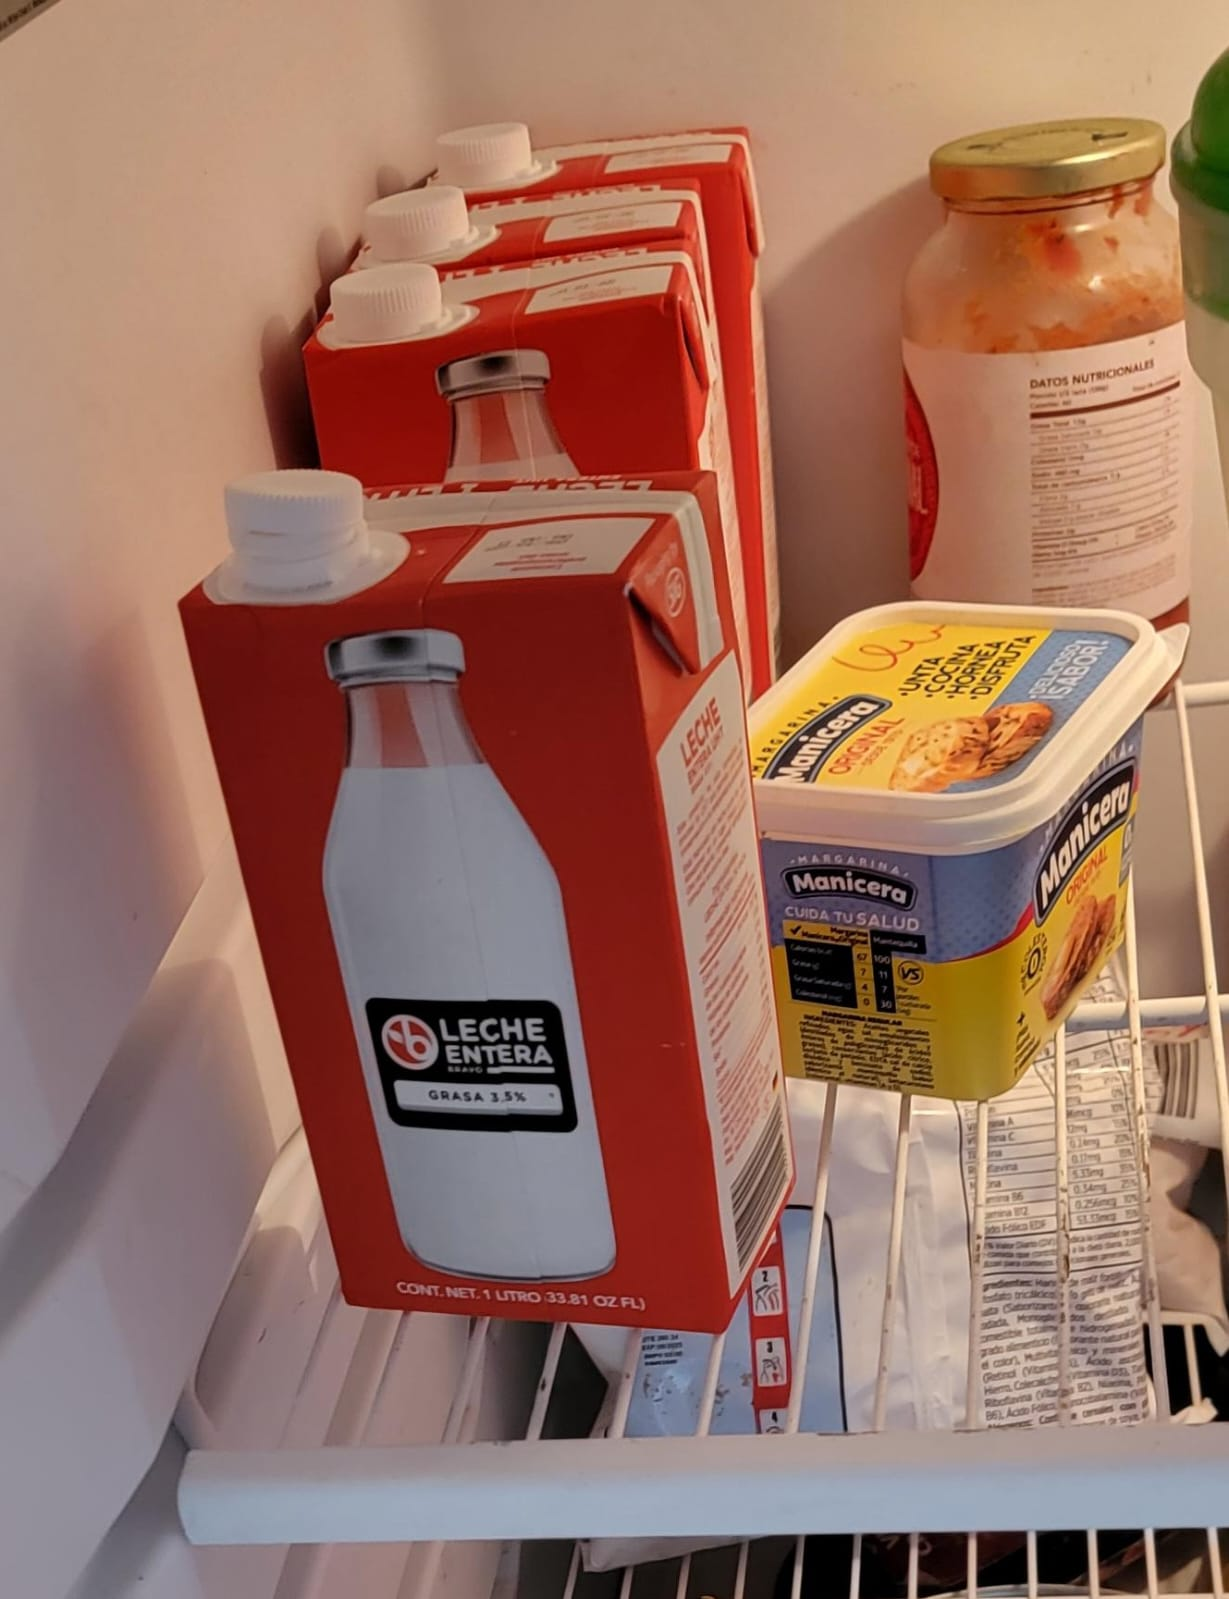


Analizando imagen...
Enviando petición a Ollama...
Código de estado: 200

Resultado del análisis:

In this image, there are a total of 6 Leche milk cartons and 2 cups of yogurt on the shelf. The milk is kept in the refrigerator to maintain its freshness and quality. This scene shows a close-up view of these products stored in a fridge, implying that they are chilling until they are ready for consumption.


In [14]:
import requests
import base64
from PIL import Image
import io
import json

class OllamaVision:
    def __init__(self, model_name="bakllava"):
        self.base_url = "http://localhost:11434/api/generate"
        self.model_name = model_name

    def encode_image(self, image_path):
        """
        Codifica una imagen a base64 con manejo mejorado de formatos.
        Acepta tanto rutas como objetos de imagen.
        """
        try:
            if isinstance(image_path, str):
                with Image.open(image_path) as img:
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    # Guardar en formato JPEG en un buffer
                    buffer = io.BytesIO()
                    img.save(buffer, format='JPEG')
                    img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
            else:
                # Si es un objeto de imagen
                img = image_path
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                buffer = io.BytesIO()
                img.save(buffer, format='JPEG')
                img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
            
            return img_str
        except Exception as e:
            print(f"Error al codificar la imagen: {str(e)}")
            return None

    def analyze_image(self, image_path, prompt):
        """Analiza una imagen usando el modelo de visión."""
        # Codificar la imagen
        base64_image = self.encode_image(image_path)
        if not base64_image:
            return "Error al procesar la imagen"
        
        # Preparar el payload
        payload = {
            "model": self.model_name,
            "prompt": prompt,
            "stream": False,
            "images": [base64_image]
        }
        
        try:
            # Hacer la petición
            print("Enviando petición a Ollama...")
            response = requests.post(self.base_url, json=payload)
            print(f"Código de estado: {response.status_code}")
            
            if response.status_code == 200:
                result = response.json()
                return result.get('response', 'No se pudo obtener una respuesta')
            else:
                print(f"Respuesta completa del servidor: {response.text}")
                return f"Error en la petición: {response.status_code}"
            
        except requests.exceptions.RequestException as e:
            print(f"Error detallado: {str(e)}")
            return f"Error en la petición: {str(e)}"

def test_vision(image_path, prompt="¿Qué ves en esta imagen?"):
    """
    Función de prueba que muestra la imagen y su análisis
    """
    from IPython.display import display, Image as IPImage
    
    # Mostrar la imagen
    print("Imagen a analizar:")
    display(IPImage(filename=image_path))
    
    # Crear instancia y analizar
    vision_client = OllamaVision()
    print("\nAnalizando imagen...")
    result = vision_client.analyze_image(image_path, prompt)
    
    print("\nResultado del análisis:")
    print(result)
    
    return result


# Probar con una imagen
resultado = test_vision('ej4.jpeg', '¿Qué productos ves en esta imagen y que cantidad de cada uno. Se especifico.?')


## Prueba del modelo sin entrenamiento previo

### Importaciones y configuración global


In [52]:
import requests
import base64
from PIL import Image
import io
import json
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from IPython.display import display, Image as IPImage

# Configuraciones globales
BASE_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "llama3.2-vision"
VALID_CLASSES = ['agua', 'leche', 'galletas']
BRANDS = {
    'agua': ['planeta azul', 'dasani', 'cascada'],
    'leche': ['carnation', 'rica', 'nestlé', 'milex'],
    'galletas': ['club social', 'oreo', 'club extra', 'guarina']
}
ERROR_CLASS = 'desconocido'

### Funciones de procesamiento de imágenes

In [53]:
def encode_image(image_path):
    """Codifica una imagen a base64 con manejo mejorado de formatos."""
    try:
        if isinstance(image_path, str):
            with Image.open(image_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                buffer = io.BytesIO()
                img.save(buffer, format='JPEG')
                img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
        else:
            img = image_path
            if img.mode != 'RGB':
                img = img.convert('RGB')
            buffer = io.BytesIO()
            img.save(buffer, format='JPEG')
            img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
        
        return img_str
    except Exception as e:
        print(f"Error al codificar la imagen: {str(e)}")
        return None

def clean_prediction(prediction: str) -> Tuple[str, str]:
    """Limpia la respuesta del modelo para extraer la categoría y la marca."""
    prediction_lower = prediction.lower()
    
    # Primero identificamos la categoría
    category_scores = {clase: 0 for clase in VALID_CLASSES}
    
    # Palabras clave para categorías
    keywords = {
        'agua': ['agua', 'botella', 'bebida', 'refresco', 'líquido'],
        'leche': ['leche', 'lácteo', 'dairy', 'milk', 'evaporada', 'condensada'],
        'galletas': ['galleta', 'cookie', 'oreo', 'snack', 'dulce', 'club social', 'cracker', 'sandwich']
    }
    
    # Evaluar categoría
    for categoria, palabras in keywords.items():
        for palabra in palabras:
            if palabra in prediction_lower:
                category_scores[categoria] += 1
    
    # Determinar categoría
    category = max(category_scores.items(), key=lambda x: x[1])[0] if max(category_scores.values()) > 0 else VALID_CLASSES[0]
    
    # Buscar marca
    brand = "marca desconocida"
    for marca in BRANDS[category]:
        if marca.lower() in prediction_lower:
            brand = marca
            break
            
    if brand == "marca desconocida":
        common_prefixes = ["marca", "producto", "de la marca", "elaborado por"]
        for prefix in common_prefixes:
            if prefix in prediction_lower:
                start_idx = prediction_lower.find(prefix) + len(prefix)
                end_idx = prediction_lower.find(" ", start_idx + 15) if " " in prediction_lower[start_idx:] else len(prediction_lower)
                potential_brand = prediction_lower[start_idx:end_idx].strip()
                if len(potential_brand) > 2:
                    brand = potential_brand
                    break
    
    return category, brand

def analyze_image(image_path: str, prompt: str) -> str:
    """Analiza una imagen usando el modelo de visión."""
    base64_image = encode_image(image_path)
    if not base64_image:
        return f"{ERROR_CLASS} (marca desconocida)"
    
    payload = {
        "model": MODEL_NAME,
        "prompt": prompt,
        "stream": False,
        "images": [base64_image]
    }
    
    try:
        print("Enviando petición a Ollama...")
        response = requests.post(BASE_URL, json=payload)
        print(f"Código de estado: {response.status_code}")
        
        if response.status_code == 200:
            result = response.json()
            prediction = result.get('response', 'No se pudo obtener una respuesta')
            category, brand = clean_prediction(prediction)
            print(f"Predicción original: {prediction}")
            print(f"Categoría: {category}")
            print(f"Marca: {brand}")
            return f"{category} ({brand})"
        else:
            print(f"Respuesta completa del servidor: {response.text}")
            return f"{ERROR_CLASS} (marca desconocida)"
        
    except requests.exceptions.RequestException as e:
        print(f"Error detallado: {str(e)}")
        return f"{ERROR_CLASS} (marca desconocida)"

### Funciones de métricas y visualización

In [54]:
def calculate_metrics(predictions: List[str], ground_truth: List[str]) -> Dict[str, float]:
    """Calcula métricas de evaluación."""
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    
    # Limpiar predicciones para obtener solo la categoría (antes del paréntesis)
    cleaned_predictions = [pred.split('(')[0].strip() for pred in predictions]
    
    y_true = le.fit_transform(ground_truth)
    y_pred = le.transform(cleaned_predictions)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro')
    }
    
    classes = le.classes_
    for i, class_name in enumerate(classes):
        y_true_binary = (y_true == i)
        y_pred_binary = (y_pred == i)
        
        metrics[f'precision_{class_name}'] = precision_score(y_true_binary, y_pred_binary)
        metrics[f'recall_{class_name}'] = recall_score(y_true_binary, y_pred_binary)
        metrics[f'f1_{class_name}'] = f1_score(y_true_binary, y_pred_binary)
        
    return metrics

def plot_confusion_matrix(predictions: List[str], ground_truth: List[str]) -> None:
    """Genera y muestra la matriz de confusión."""
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    
    # Limpiar predicciones para obtener solo la categoría
    cleaned_predictions = [pred.split('(')[0].strip() for pred in predictions]
    
    y_true = le.fit_transform(ground_truth)
    y_pred = le.transform(cleaned_predictions)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, 
               annot=True, 
               fmt='d', 
               cmap='Blues',
               xticklabels=le.classes_,
               yticklabels=le.classes_)
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Predicción')
    plt.show()

### Función principal de prueba

In [55]:
def test_vision_with_metrics(image_paths: List[str], 
                           ground_truth: List[str] = None, 
                           prompt: str = None) -> Dict[str, float]:
    """Función de prueba que evalúa múltiples imágenes y muestra métricas."""
    
    if ground_truth is None:
        ground_truth = ['galletas'] * len(image_paths)
    
    if len(image_paths) != len(ground_truth):
        print("ADVERTENCIA: El número de imágenes no coincide con el número de etiquetas ground truth")
        if len(image_paths) > len(ground_truth):
            ground_truth.extend([ground_truth[-1]] * (len(image_paths) - len(ground_truth)))
        else:
            ground_truth = ground_truth[:len(image_paths)]
    
    if prompt is None:
        prompt = f"Identifica qué tipo de producto ves en esta imagen y su marca. El producto debe ser uno de estos: {', '.join(VALID_CLASSES)}. Menciona explícitamente tanto el tipo de producto como la marca, especialmente si es una marca dominicana como Planeta Azul, Club Social, Rica, etc."
    
    print("Ejemplos de imágenes a analizar:")
    for i, path in enumerate(image_paths):
        try:
            display(IPImage(filename=path))
            print(f"Ground truth: {ground_truth[i]}\n")
        except Exception as e:
            print(f"Error al mostrar la imagen {path}: {str(e)}")
    
    print("\nProcesando imágenes...")
    predictions = []
    
    for i, image_path in enumerate(image_paths):
        print(f"\nProcesando imagen {i+1}/{len(image_paths)}: {image_path}")
        prediction = analyze_image(image_path, prompt)
        predictions.append(prediction)
    
    print("\nResumen de predicciones:")
    for i, (pred, true) in enumerate(zip(predictions, ground_truth)):
        print(f"Imagen {i+1}: Predicción = {pred}, Ground Truth = {true}")
    
    metrics = calculate_metrics(predictions, ground_truth)
    plot_confusion_matrix(predictions, ground_truth)
    
    print("\nMétricas de evaluación:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    return metrics

### Ejecucion de los metodos:

Ejemplos de imágenes a analizar:


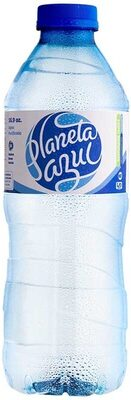

Ground truth: agua



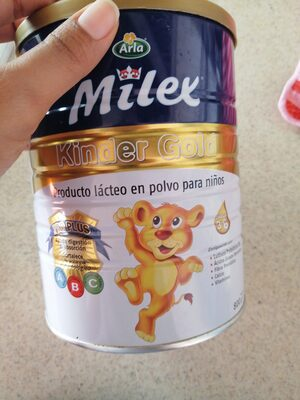

Ground truth: leche



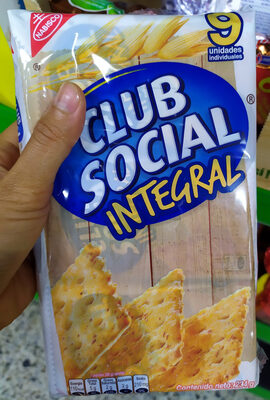

Ground truth: galletas



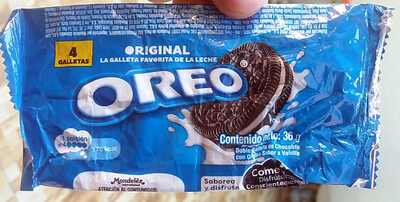

Ground truth: galletas



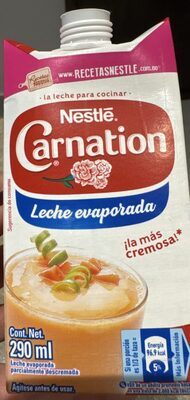

Ground truth: leche


Procesando imágenes...

Procesando imagen 1/5: 37_Planeta Azul.jpg
Enviando petición a Ollama...
Código de estado: 200
Predicción original: El producto que se aprecia en esta imagen es un envase con agua mineral y su marca es Planeta Azul.

El agua mineral tiene las siguientes características: 

*   Es la bebida más consumida del mundo.
*   Contiene sales minerales que pueden ser beneficiosas para el organismo.
*   Puede tener diferentes sabores dependiendo de la fuente de donde se obtenga. (Agua mineral natural, saborizada, etc.)
*   Debe llevar etiqueta que indique su origen y composición química.

La marca Planeta Azul es una empresa dominicana que ha logrado posicionarse como líder en el mercado de agua mineral del país.
Categoría: agua
Marca: planeta azul

Procesando imagen 2/5: 197_leche.jpg
Enviando petición a Ollama...
Código de estado: 200
Predicción original: El producto que se observa en esta imagen es un polvo para preparar bebida láctea, específicamen

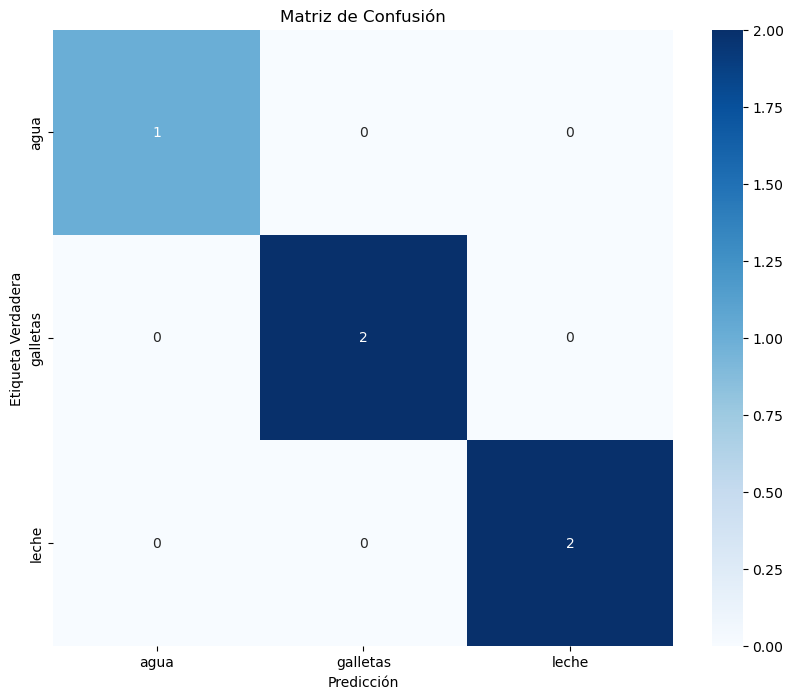


Métricas de evaluación:
accuracy: 1.0000
precision_macro: 1.0000
recall_macro: 1.0000
f1_macro: 1.0000
precision_agua: 1.0000
recall_agua: 1.0000
f1_agua: 1.0000
precision_galletas: 1.0000
recall_galletas: 1.0000
f1_galletas: 1.0000
precision_leche: 1.0000
recall_leche: 1.0000
f1_leche: 1.0000


In [56]:
# Celda 5: Ejecución de prueba
image_paths = ['37_Planeta Azul.jpg', '197_leche.jpg', '4_Club Social Integral Tradicion.jpg', '7_Oreo Original.jpg', '127_Carnation Evaporated Milk.jpg']
ground_truth = ['agua', 'leche', 'galletas', 'galletas', 'leche']
metrics = test_vision_with_metrics(image_paths, ground_truth)

In [57]:
import requests
import base64
from PIL import Image
import io
from typing import List, Dict, Tuple
from sklearn.metrics import accuracy_score
import json
import os

class VisionCatalog:
    def __init__(self):
        self.base_url = "http://localhost:11434/api/generate"
        self.model_name = "llama3.2-vision"
        self.catalog: Dict[str, Dict] = {}
        self.valid_classes = ['agua', 'leche', 'galletas']
        
    def encode_image(self, image_path: str) -> str:
        try:
            with Image.open(image_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                buffer = io.BytesIO()
                img.save(buffer, format='JPEG')
                return base64.b64encode(buffer.getvalue()).decode('utf-8')
        except Exception as e:
            print(f"Error encoding image: {e}")
            return None

    def add_reference_product(self, image_path: str, product_info: Dict[str, str]) -> None:
        """
        Añade un producto de referencia al catálogo.
        product_info debe contener 'category' y 'brand'
        """
        img_str = self.encode_image(image_path)
        if img_str:
            product_id = f"{product_info['category']}_{product_info['brand']}"
            self.catalog[product_id] = {
                'image': img_str,
                'info': product_info
            }

    def build_catalog_from_directory(self, directory: str, catalog_file: str) -> None:
        """
        Construye el catálogo a partir de un directorio de imágenes y un archivo JSON de metadatos.
        """
        with open(catalog_file, 'r') as f:
            metadata = json.load(f)
        
        for filename, info in metadata.items():
            image_path = os.path.join(directory, filename)
            if os.path.exists(image_path):
                self.add_reference_product(image_path, info)

    def analyze_image(self, image_path: str) -> str:
        """
        Analiza una imagen comparándola con el catálogo de referencia.
        """
        img_str = self.encode_image(image_path)
        if not img_str:
            return "desconocido (marca desconocida)"

        # Construir el prompt incluyendo ejemplos del catálogo
        prompt = self._build_few_shot_prompt(img_str)
        
        payload = {
            "model": self.model_name,
            "prompt": prompt,
            "stream": False,
            "images": [img_str] + [item['image'] for item in self.catalog.values()]
        }
        
        try:
            response = requests.post(self.base_url, json=payload)
            if response.status_code == 200:
                prediction = response.json().get('response', '')
                return self._parse_prediction(prediction)
            return "desconocido (marca desconocida)"
        except Exception as e:
            print(f"Error en análisis: {e}")
            return "desconocido (marca desconocida)"

    def _build_few_shot_prompt(self, target_image: str) -> str:
        """
        Construye un prompt con ejemplos del catálogo para mejorar la precisión.
        """
        prompt = "Voy a mostrarte algunos ejemplos de productos y luego necesito que identifiques uno nuevo.\n\n"
        
        # Añadir ejemplos del catálogo
        for product_id, data in self.catalog.items():
            info = data['info']
            prompt += f"Para este producto: {info['category']} ({info['brand']})\n"
        
        prompt += "\nAhora, para la nueva imagen, dime solo: [CATEGORIA] (MARCA)\n"
        prompt += "Usa solamente las categorías: " + ", ".join(self.valid_classes)
        
        return prompt

    def _parse_prediction(self, prediction: str) -> str:
        """
        Parsea la predicción del modelo y la formatea correctamente.
        """
        prediction = prediction.lower().strip()
        
        # Buscar la categoría más probable
        category = next((c for c in self.valid_classes if c in prediction), "desconocido")
        
        # Extraer la marca si está entre paréntesis
        brand = "marca desconocida"
        if '(' in prediction and ')' in prediction:
            brand = prediction.split('(')[1].split(')')[0].strip()
        
        return f"{category} ({brand})"

    def save_catalog(self, filename: str) -> None:
        """
        Guarda el catálogo en un archivo JSON.
        """
        catalog_data = {k: v['info'] for k, v in self.catalog.items()}
        with open(filename, 'w') as f:
            json.dump(catalog_data, f, indent=2)

    def load_catalog(self, filename: str) -> None:
        """
        Carga un catálogo previamente guardado.
        """
        with open(filename, 'r') as f:
            catalog_data = json.load(f)
        self.catalog = catalog_data

# Ejemplo de uso
def setup_catalog_example():
    """
    Ejemplo de cómo configurar y usar el catálogo.
    """
    catalog = VisionCatalog()
    
    # Estructura del archivo catalog_metadata.json
    metadata = {
        "planeta_azul.jpg": {
            "category": "agua",
            "brand": "planeta azul"
        },
        "leche_carnation.jpg": {
            "category": "leche",
            "brand": "carnation"
        },
        # ... más productos
    }
    
    # Guardar metadata
    with open('catalog_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Construir catálogo
    catalog.build_catalog_from_directory('reference_images', 'catalog_metadata.json')
    
    return catalog

In [58]:
import requests
import base64
from PIL import Image
import io
from typing import List, Dict, Tuple
from sklearn.metrics import accuracy_score
import json
import os
from IPython.display import display, Image as IPImage

class VisionCatalog:
    def __init__(self):
        self.base_url = "http://localhost:11434/api/generate"
        self.model_name = "llama3.2-vision"
        self.catalog: Dict[str, Dict] = {}
        self.valid_classes = ['agua', 'leche', 'galletas', 'cereal', 
                            'bebida', 'bebida_vegetal', 'snack', 'chocolates']
        
    def _build_few_shot_prompt(self, target_image: str) -> str:
        """
        Construye un prompt más específico para el modelo
        """
        prompt = (
            "Eres un sistema experto en identificación de productos alimenticios.\n"
            "IMPORTANTE: Responde SOLAMENTE con el formato exacto: [CATEGORIA] (MARCA)\n\n"
            f"Las categorías permitidas son: {', '.join(self.valid_classes)}\n"
            "Ejemplos de respuestas válidas:\n"
            "agua (planeta azul)\n"
            "leche (carnation)\n"
            "galletas (oreo)\n\n"
            "Analiza la imagen y responde usando EXACTAMENTE ese formato.\n"
            "NO agregues ningún texto adicional.\n"
        )
        return prompt

    def analyze_image(self, image_path: str) -> str:
        img_str = self.encode_image(image_path)
        if not img_str:
            return "desconocido (marca desconocida)"

        prompt = self._build_few_shot_prompt(img_str)
        
        print("Prompt enviado al modelo:")
        print(prompt)
        
        payload = {
            "model": self.model_name,
            "prompt": prompt,
            "stream": False,
            "images": [img_str]
        }
        
        try:
            print("\nEnviando petición a Ollama...")
            response = requests.post(self.base_url, json=payload)
            print(f"Código de estado: {response.status_code}")
            
            if response.status_code == 200:
                result = response.json()
                prediction = result.get('response', '')
                print(f"\nRespuesta del modelo: {prediction}")
                
                # Mejor manejo de la predicción
                prediction = prediction.lower().strip()
                if not any(c in prediction for c in self.valid_classes):
                    return "desconocido (marca desconocida)"
                    
                return self._parse_prediction(prediction)
            else:
                print(f"Error en la respuesta: {response.text}")
                return "desconocido (marca desconocida)"
        except Exception as e:
            print(f"Error en análisis: {str(e)}")
            return "desconocido (marca desconocida)"

    def _parse_prediction(self, prediction: str) -> str:
        """
        Mejora del parsing de la predicción
        """
        prediction = prediction.lower().strip()
        
        # Buscar categoría
        category = next((c for c in self.valid_classes if c in prediction), "desconocido")
        
        # Buscar marca
        brand = "marca desconocida"
        if '(' in prediction and ')' in prediction:
            brand_text = prediction.split('(')[1].split(')')[0].strip()
            if brand_text and brand_text != "marca desconocida":
                brand = brand_text
        
        return f"{category} ({brand})"
        
    def encode_image(self, image_path: str) -> str:
        try:
            with Image.open(image_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                buffer = io.BytesIO()
                img.save(buffer, format='JPEG')
                return base64.b64encode(buffer.getvalue()).decode('utf-8')
        except Exception as e:
            print(f"Error encoding image: {e}")
            return None

    def add_reference_product(self, image_path: str, product_info: Dict[str, str]) -> None:
        img_str = self.encode_image(image_path)
        if img_str:
            product_id = f"{product_info['category']}_{product_info['brand']}"
            self.catalog[product_id] = {
                'image': img_str,
                'info': product_info
            }

    def build_catalog_from_directory(self, directory: str, catalog_file: str) -> None:
        with open(catalog_file, 'r') as f:
            metadata = json.load(f)
        
        for filename, info in metadata.items():
            image_path = os.path.join(directory, filename)
            if os.path.exists(image_path):
                self.add_reference_product(image_path, info)
                print(f"Añadido al catálogo: {filename}")

In [59]:
# Configuración de rutas
BASE_PATH = "/home/friasluna/Tesis_Proyect/proyecto_tesis/modelo/jupyer_notebook/dataset/imagenes_productos"
CATALOG_FILE = "catalog_metadata.json"

# Crear el catálogo de productos de referencia
reference_products = {
    "37_Planeta Azul.jpg": {
        "category": "agua",
        "brand": "planeta azul"
    },
    "127_Carnation Evaporated Milk.jpg": {
        "category": "leche",
        "brand": "carnation"
    },
    "197_leche.jpg": {
        "category": "leche",
        "brand": "rica"
    },
    "7_Oreo Original.jpg": {
        "category": "galletas",
        "brand": "oreo"
    },
    "4_Club Social Integral Tradicion.jpg": {
        "category": "galletas",
        "brand": "club social"
    },
    "27_Avena quaker proteina.jpg": {
        "category": "cereal",
        "brand": "quaker"
    },
    "22_Malta Morena.jpg": {
        "category": "bebida",
        "brand": "malta morena"
    },
    "198_Almond milk.jpg": {
        "category": "bebida_vegetal",
        "brand": "silk"
    }
}

# Guardar el catálogo
with open(CATALOG_FILE, 'w', encoding='utf-8') as f:
    json.dump(reference_products, f, indent=2, ensure_ascii=False)

print("Catálogo guardado exitosamente")

Catálogo guardado exitosamente


Añadido al catálogo: 37_Planeta Azul.jpg
Añadido al catálogo: 127_Carnation Evaporated Milk.jpg
Añadido al catálogo: 197_leche.jpg
Añadido al catálogo: 7_Oreo Original.jpg
Añadido al catálogo: 4_Club Social Integral Tradicion.jpg
Añadido al catálogo: 27_Avena quaker proteina.jpg
Añadido al catálogo: 22_Malta Morena.jpg
Añadido al catálogo: 198_Almond milk.jpg

Probando el sistema de reconocimiento:
--------------------------------------------------


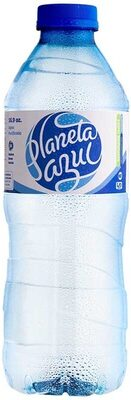

Prompt enviado al modelo:
Eres un sistema experto en identificación de productos alimenticios.
IMPORTANTE: Responde SOLAMENTE con el formato exacto: [CATEGORIA] (MARCA)

Las categorías permitidas son: agua, leche, galletas, cereal, bebida, bebida_vegetal, snack, chocolates
Ejemplos de respuestas válidas:
agua (planeta azul)
leche (carnation)
galletas (oreo)

Analiza la imagen y responde usando EXACTAMENTE ese formato.
NO agregues ningún texto adicional.


Enviando petición a Ollama...
Código de estado: 200

Respuesta del modelo: agua (Planeta Azul)
Imagen: 37_Planeta Azul.jpg
Predicción: agua (planeta azul)



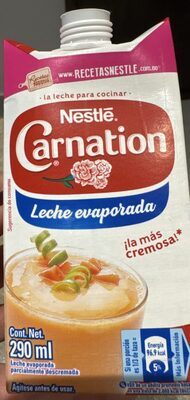

Prompt enviado al modelo:
Eres un sistema experto en identificación de productos alimenticios.
IMPORTANTE: Responde SOLAMENTE con el formato exacto: [CATEGORIA] (MARCA)

Las categorías permitidas son: agua, leche, galletas, cereal, bebida, bebida_vegetal, snack, chocolates
Ejemplos de respuestas válidas:
agua (planeta azul)
leche (carnation)
galletas (oreo)

Analiza la imagen y responde usando EXACTAMENTE ese formato.
NO agregues ningún texto adicional.


Enviando petición a Ollama...
Código de estado: 200

Respuesta del modelo: Bebida (Carnation)
Imagen: 127_Carnation Evaporated Milk.jpg
Predicción: bebida (carnation)



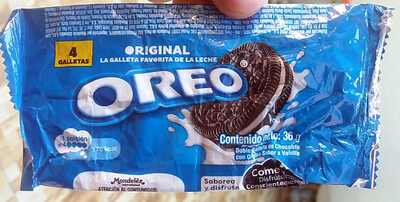

Prompt enviado al modelo:
Eres un sistema experto en identificación de productos alimenticios.
IMPORTANTE: Responde SOLAMENTE con el formato exacto: [CATEGORIA] (MARCA)

Las categorías permitidas son: agua, leche, galletas, cereal, bebida, bebida_vegetal, snack, chocolates
Ejemplos de respuestas válidas:
agua (planeta azul)
leche (carnation)
galletas (oreo)

Analiza la imagen y responde usando EXACTAMENTE ese formato.
NO agregues ningún texto adicional.


Enviando petición a Ollama...
Código de estado: 200

Respuesta del modelo: Galletas (Oreo)
Imagen: 7_Oreo Original.jpg
Predicción: galletas (oreo)



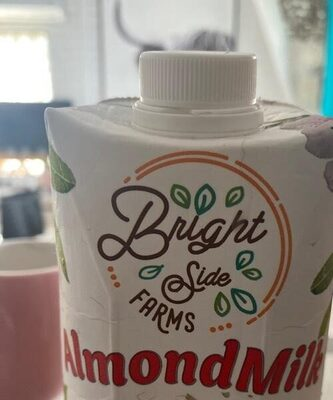

Prompt enviado al modelo:
Eres un sistema experto en identificación de productos alimenticios.
IMPORTANTE: Responde SOLAMENTE con el formato exacto: [CATEGORIA] (MARCA)

Las categorías permitidas son: agua, leche, galletas, cereal, bebida, bebida_vegetal, snack, chocolates
Ejemplos de respuestas válidas:
agua (planeta azul)
leche (carnation)
galletas (oreo)

Analiza la imagen y responde usando EXACTAMENTE ese formato.
NO agregues ningún texto adicional.


Enviando petición a Ollama...
Código de estado: 200

Respuesta del modelo: Bebida_vegetal (Bright Side Farms)
Imagen: 198_Almond milk.jpg
Predicción: bebida (bright side farms)



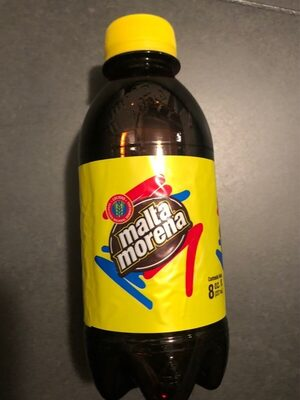

Prompt enviado al modelo:
Eres un sistema experto en identificación de productos alimenticios.
IMPORTANTE: Responde SOLAMENTE con el formato exacto: [CATEGORIA] (MARCA)

Las categorías permitidas son: agua, leche, galletas, cereal, bebida, bebida_vegetal, snack, chocolates
Ejemplos de respuestas válidas:
agua (planeta azul)
leche (carnation)
galletas (oreo)

Analiza la imagen y responde usando EXACTAMENTE ese formato.
NO agregues ningún texto adicional.


Enviando petición a Ollama...
Código de estado: 200

Respuesta del modelo: bebida (malta morena)
Imagen: 22_Malta Morena.jpg
Predicción: bebida (malta morena)



In [60]:
# Inicializar el catálogo
catalog = VisionCatalog()

# Construir el catálogo desde el directorio
catalog.build_catalog_from_directory(BASE_PATH, CATALOG_FILE)

# Lista de imágenes para probar
test_images = [
    os.path.join(BASE_PATH, "37_Planeta Azul.jpg"),
    os.path.join(BASE_PATH, "127_Carnation Evaporated Milk.jpg"),
    os.path.join(BASE_PATH, "7_Oreo Original.jpg"),
    os.path.join(BASE_PATH, "198_Almond milk.jpg"),
    os.path.join(BASE_PATH, "22_Malta Morena.jpg")
]

# Probar el sistema
print("\nProbando el sistema de reconocimiento:")
print("-" * 50)
for image_path in test_images:
    # Mostrar la imagen
    display(IPImage(filename=image_path))
    
    # Obtener y mostrar la predicción
    result = catalog.analyze_image(image_path)
    print(f"Imagen: {os.path.basename(image_path)}")
    print(f"Predicción: {result}\n")

In [62]:
import os
import json
from typing import Dict, List, Tuple
import requests
import base64
from PIL import Image
import io
from pathlib import Path
import numpy as np
import cv2

class EnhancedVisionClassifier:
    def __init__(self):
        self.BASE_URL = "http://localhost:11434/api/generate"
        self.MODEL_NAME = "llava"
        self.categories = {
            'biscuits': {
                'brands': ['Casino', 'Club Social', 'Oreo', 'Ritz', 'Costa', 'Emperador', 'FRAC', 'Guarina', 'Max'],
                'keywords': ['galleta', 'cookie', 'cracker', 'wafer', 'biscuit', 'snack']
            },
            'canned': {
                'brands': ['La Famosa', 'Goya', 'Del Monte'],
                'keywords': ['enlatado', 'conserva', 'lata', 'atún', 'sardina']
            },
            'cereals': {
                'brands': ['Nesquik', 'Corn Flakes', 'Trix', 'Gran Cereal'],
                'keywords': ['cereal', 'avena', 'corn', 'granola', 'harina']
            },
            'dried-foods': {
                'brands': ['Nesquik', 'Sustagen'],
                'keywords': ['polvo', 'deshidratado', 'instantáneo']
            },
            'milk-powder': {
                'brands': ['Milex', 'Nido', 'Carnation', 'Leche Entera'],
                'keywords': ['leche', 'milk', 'lácteo', 'fórmula']
            },
            'water': {
                'brands': ['Planeta Azul', 'Dasani', 'Cascada'],
                'keywords': ['agua', 'water', 'bebida', 'botella']
            }
        }
        self.dataset_knowledge = {}
        self.product_features = {}
        
    def load_and_process_dataset(self, dataset_path: str):
        """Carga y procesa el dataset, extrayendo características visuales de las imágenes"""
        print(f"\nProcesando dataset en: {dataset_path}")
        
        for category in self.categories.keys():
            category_path = Path(dataset_path) / category
            if not category_path.exists():
                continue
                
            self.product_features[category] = []
            for img_file in category_path.glob('*.[jJ][pP][gG]'):
                if 'WhatsApp' not in img_file.name:
                    try:
                        # Extraer características visuales
                        img = cv2.imread(str(img_file))
                        if img is None:
                            continue
                            
                        # Convertir a RGB y redimensionar
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (224, 224))
                        
                        # Extraer características básicas
                        features = {
                            'name': img_file.stem,
                            'hist': cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten(),
                            'dominant_colors': self._get_dominant_colors(img),
                            'edges': self._get_edge_density(img)
                        }
                        
                        self.product_features[category].append(features)
                        
                    except Exception as e:
                        print(f"Error procesando {img_file}: {e}")
                        
        print("Dataset procesado y características extraídas")

    def _get_dominant_colors(self, img, n_colors=5):
        """Extrae los colores dominantes de una imagen"""
        pixels = img.reshape(-1, 3)
        pixels = np.float32(pixels)
        
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
        flags = cv2.KMEANS_RANDOM_CENTERS
        
        _, labels, centers = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
        
        _, counts = np.unique(labels, return_counts=True)
        return centers[np.argsort(-counts)]
        
    def _get_edge_density(self, img):
        """Calcula la densidad de bordes en la imagen"""
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        return np.mean(edges > 0)

    def generate_enhanced_prompt(self, image_path: str, image_features: Dict) -> str:
        """Genera un prompt mejorado basado en características de la imagen"""
        base_prompt = (
            f"Analiza esta imagen y clasifícala. La imagen muestra un producto que podría ser:\n\n"
        )
        
        # Agregar información específica de cada categoría
        for category, info in self.categories.items():
            base_prompt += f"- {category.upper()}: {', '.join(info['brands'])}\n"
            base_prompt += f"  Características típicas: {', '.join(info['keywords'])}\n"
        
        # Agregar información sobre características visuales detectadas
        base_prompt += "\nCaracterísticas detectadas en la imagen:\n"
        base_prompt += f"- Densidad de bordes: {'alta' if image_features['edges'] > 0.1 else 'baja'}\n"
        base_prompt += f"- Colores dominantes: {len(image_features['dominant_colors'])} colores principales\n"
        
        base_prompt += "\nResponde SOLO con el formato: 'categoría (marca)'"
        return base_prompt

    def classify_image(self, image_path: str) -> Tuple[str, str]:
        """Clasifica una imagen usando el modelo mejorado"""
        try:
            # Cargar y procesar la imagen
            img = cv2.imread(image_path)
            if img is None:
                return "error", "error (imagen no válida)"
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            
            # Extraer características
            image_features = {
                'hist': cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten(),
                'dominant_colors': self._get_dominant_colors(img),
                'edges': self._get_edge_density(img)
            }
            
            # Generar prompt mejorado
            prompt = self.generate_enhanced_prompt(image_path, image_features)
            
            # Codificar imagen
            with open(image_path, 'rb') as img_file:
                base64_image = base64.b64encode(img_file.read()).decode('utf-8')
            
            # Preparar payload
            payload = {
                "model": self.MODEL_NAME,
                "prompt": prompt,
                "stream": False,
                "images": [base64_image]
            }
            
            # Realizar petición
            response = requests.post(self.BASE_URL, json=payload)
            if response.status_code != 200:
                return "error", f"error (código {response.status_code})"
                
            result = response.json()
            prediction = result.get('response', '').lower()
            
            # Procesar predicción
            best_category = None
            best_brand = None
            max_score = 0
            
            for category, info in self.categories.items():
                # Verificar keywords
                keyword_score = sum(1 for keyword in info['keywords'] if keyword in prediction)
                
                # Verificar marcas
                brand_score = 0
                detected_brand = None
                for brand in info['brands']:
                    if brand.lower() in prediction:
                        brand_score = 1
                        detected_brand = brand
                        break
                
                total_score = keyword_score + (brand_score * 2)
                if total_score > max_score:
                    max_score = total_score
                    best_category = category
                    best_brand = detected_brand
            
            if best_category:
                return best_category, best_brand if best_brand else "marca desconocida"
            
            return "desconocido", "marca desconocida"
            
        except Exception as e:
            print(f"Error en clasificación: {e}")
            return "error", f"error ({str(e)})"

    def batch_classify(self, image_paths: List[str]) -> List[Tuple[str, str]]:
        """Clasifica un lote de imágenes"""
        results = []
        for path in image_paths:
            category, brand = self.classify_image(path)
            results.append((path, category, brand))
        return results

In [64]:
# Ejemplo de uso
if __name__ == "__main__":
    classifier = EnhancedVisionClassifier()
    
    # Configurar y cargar dataset
    dataset_path = "dataset/train/images"
    classifier.load_and_process_dataset(dataset_path)
    
    # Ejemplo de clasificación
    test_image = "37_Planeta Azul.jpg"
    category, brand = classifier.classify_image(test_image)
    print(f"\nResultado de clasificación:")
    print(f"Imagen: {test_image}")
    print(f"Categoría: {category}")
    print(f"Marca: {brand}")


Procesando dataset en: dataset/train/images
Dataset procesado y características extraídas

Resultado de clasificación:
Imagen: 37_Planeta Azul.jpg
Categoría: water
Marca: Planeta Azul


In [66]:
import os
import json
from typing import Dict, List, Tuple, Union
import requests
import base64
from PIL import Image
import io
import re
from pathlib import Path
import numpy as np
import cv2

class EnhancedVisionClassifier:
    def __init__(self):
        self.BASE_URL = "http://localhost:11434/api/generate"
        self.MODEL_NAME = "llava"
        self.categories = {
            'biscuits': {
                'brands': ['Casino', 'Club Social', 'Oreo', 'Ritz', 'Costa', 'Emperador', 'FRAC', 'Guarina'],
                'keywords': ['galleta', 'cookie', 'cracker', 'wafer', 'biscuit', 'snack']
            },
            'canned': {
                'brands': ['La Famosa', 'Goya', 'Del Monte'],
                'keywords': ['enlatado', 'conserva', 'lata', 'atún', 'sardina']
            },
            'cereals': {
                'brands': ['Nesquik', 'Corn Flakes', 'Trix', 'Gran Cereal'],
                'keywords': ['cereal', 'avena', 'corn', 'granola', 'harina']
            },
            'dried-foods': {
                'brands': ['Nesquik', 'Sustagen'],
                'keywords': ['polvo', 'deshidratado', 'instantáneo']
            },
            'milk-powder': {
                'brands': ['Milex', 'Nido', 'Carnation'],
                'keywords': ['leche', 'milk', 'lácteo', 'fórmula']
            },
            'water': {
                'brands': ['Planeta Azul', 'Dasani', 'Cascada'],
                'keywords': ['agua', 'water', 'bebida', 'botella']
            }
        }
        self.dataset_knowledge = {}
        self.product_features = {}
        
    def load_and_process_dataset(self, dataset_path: str):
        """Carga y procesa el dataset, extrayendo características visuales de las imágenes"""
        print(f"\nProcesando dataset en: {dataset_path}")
        
        for category in self.categories.keys():
            category_path = Path(dataset_path) / category
            if not category_path.exists():
                continue
                
            self.product_features[category] = []
            for img_file in category_path.glob('*.[jJ][pP][gG]'):
                if 'WhatsApp' not in img_file.name:
                    try:
                        # Extraer características visuales
                        img = cv2.imread(str(img_file))
                        if img is None:
                            continue
                            
                        # Convertir a RGB y redimensionar
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (224, 224))
                        
                        # Extraer características básicas
                        features = {
                            'name': img_file.stem,
                            'hist': cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten(),
                            'dominant_colors': self._get_dominant_colors(img),
                            'edges': self._get_edge_density(img)
                        }
                        
                        self.product_features[category].append(features)
                        
                    except Exception as e:
                        print(f"Error procesando {img_file}: {e}")
                        
        print("Dataset procesado y características extraídas")

    def _get_dominant_colors(self, img, n_colors=5):
        """Extrae los colores dominantes de una imagen"""
        pixels = img.reshape(-1, 3)
        pixels = np.float32(pixels)
        
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
        flags = cv2.KMEANS_RANDOM_CENTERS
        
        _, labels, centers = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
        
        _, counts = np.unique(labels, return_counts=True)
        return centers[np.argsort(-counts)]
        
    def _get_edge_density(self, img):
        """Calcula la densidad de bordes en la imagen"""
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        return np.mean(edges > 0)

    def generate_enhanced_prompt(self, image_path: str, image_features: Dict) -> str:
        """Genera un prompt mejorado basado en características de la imagen"""
        base_prompt = (
            f"Analiza detalladamente esta imagen y enumera TODOS los productos visibles. "
            f"IMPORTANTE: Si hay múltiples unidades del mismo producto, cuéntalas. "
            f"Si hay productos diferentes en la misma imagen, enuméralos por separado.\n\n"
            f"Para cada producto que veas, necesito:\n"
            f"1. Categoría exacta (elige de la lista proporcionada)\n"
            f"2. Marca específica\n"
            f"3. Cantidad precisa de unidades\n\n"
            f"Para la categoría milk-powder, busca específicamente:\n"
            f"- Cajas o envases de leche\n"
            f"- Leche en polvo o líquida\n"
            f"- Marcas como Milex, Nido, Carnation o Leche Entera\n\n"
            f"Los productos deben clasificarse en una de estas categorías:\n\n"
        )
        
        # Agregar información específica de cada categoría
        for category, info in self.categories.items():
            base_prompt += f"- {category.upper()}: {', '.join(info['brands'])}\n"
            base_prompt += f"  Características típicas: {', '.join(info['keywords'])}\n"
        
        # Agregar información sobre características visuales detectadas
        base_prompt += "\nCaracterísticas detectadas en la imagen:\n"
        base_prompt += f"- Densidad de bordes: {'alta' if image_features['edges'] > 0.1 else 'baja'}\n"
        base_prompt += f"- Colores dominantes: {len(image_features['dominant_colors'])} colores principales\n"
        
        base_prompt += "\nResponde en formato JSON como este ejemplo:\n"
        base_prompt += """[
            {"category": "milk-powder", "brand": "Leche Entera", "quantity": 4},
            {"category": "cereals", "brand": "Corn Flakes", "quantity": 1}
        ]"""
        return base_prompt

    def classify_image(self, image_path: str) -> List[Dict[str, Union[str, int]]]:
        """Clasifica múltiples productos en una imagen y cuenta cantidades
        
        Returns:
            List[Dict]: Lista de productos detectados con su categoría, marca y cantidad
        """
        try:
            # Cargar y procesar la imagen
            img = cv2.imread(image_path)
            if img is None:
                return "error", "error (imagen no válida)"
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            
            # Extraer características
            image_features = {
                'hist': cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten(),
                'dominant_colors': self._get_dominant_colors(img),
                'edges': self._get_edge_density(img)
            }
            
            # Generar prompt mejorado
            prompt = self.generate_enhanced_prompt(image_path, image_features)
            
            # Codificar imagen
            with open(image_path, 'rb') as img_file:
                base64_image = base64.b64encode(img_file.read()).decode('utf-8')
            
            # Preparar payload
            payload = {
                "model": self.MODEL_NAME,
                "prompt": prompt,
                "stream": False,
                "images": [base64_image]
            }
            
            # Realizar petición
            response = requests.post(self.BASE_URL, json=payload)
            if response.status_code != 200:
                return "error", f"error (código {response.status_code})"
                
            result = response.json()
            prediction = result.get('response', '').lower()
            
            # Procesar predicción
            products = []
            
            # Primero intentar encontrar un formato JSON en la respuesta
            json_matches = re.findall(r'\[.*\]', prediction.replace('\n', ' '))
            if json_matches:
                try:
                    products = json.loads(json_matches[0])
                    if isinstance(products, list):
                        return products
                except json.JSONDecodeError:
                    pass
                    
            # Si no se encontró JSON válido, procesar el texto
            print("Procesando respuesta en texto plano:", prediction)
            # Procesamiento mejorado del texto
            found_products = {}
            
            # Patrones de cantidad más específicos
            quantity_patterns = [
                r'(\d+)\s*(?:unidades?|cajas?|paquetes?|botellas?|envases?)',
                r'hay\s*(\d+)',
                r'se ven\s*(\d+)',
                r'(\d+)\s*productos?',
                r'cantidad[:\s]+(\d+)',
                r'(\d+)\s*(?:milk|leche|agua|galletas?|cereales?)'
            ]
            
            # Procesar por categoría
            for category, info in self.categories.items():
                category_keywords = set(info['keywords'])
                category_brands = set(brand.lower() for brand in info['brands'])
                
                # Buscar coincidencias de categoría
                if any(keyword in prediction.lower() for keyword in category_keywords):
                    # Buscar marcas específicas
                    for brand in info['brands']:
                        brand_lower = brand.lower()
                        if brand_lower in prediction.lower():
                            product_key = f"{category}-{brand}"
                            if product_key not in found_products:
                                # Buscar cantidad usando todos los patrones
                                quantities = []
                                for pattern in quantity_patterns:
                                    matches = re.findall(pattern, prediction.lower())
                                    quantities.extend(matches)
                                
                                # Si encontramos cantidades, usar la más grande
                                quantity = 1
                                if quantities:
                                    quantity = max(int(q) for q in quantities if q.isdigit())
                                
                                products.append({
                                    "category": category,
                                    "brand": brand,
                                    "quantity": quantity
                                })
                                found_products[product_key] = True
                                
                                print(f"Encontrado: {category} - {brand} - {quantity} unidades")
            
            if not products:
                products.append({
                    "category": "desconocido",
                    "brand": "marca desconocida",
                    "quantity": 1
                })
            
            return products
            
        except Exception as e:
            print(f"Error en clasificación: {e}")
            return "error", f"error ({str(e)})"

    def batch_classify(self, image_paths: List[str]) -> List[Tuple[str, str]]:
        """Clasifica un lote de imágenes"""
        results = []
        for path in image_paths:
            category, brand = self.classify_image(path)
            results.append((path, category, brand))
        return results

# Ejemplo de uso
if __name__ == "__main__":
    classifier = EnhancedVisionClassifier()
    
    # Configurar y cargar dataset
    dataset_path = "dataset/train/images"
    classifier.load_and_process_dataset(dataset_path)
    
    # Ejemplo de clasificación
    test_image = "ej4.jpeg"
    category, brand = classifier.classify_image(test_image)
    print(f"\nResultado de clasificación:")
    print(f"Imagen: {test_image}")
    print(f"Categoría: {category}")
    print(f"Marca: {brand}")


Procesando dataset en: dataset/train/images
Dataset procesado y características extraídas

Resultado de clasificación:
Imagen: ej4.jpeg
Categoría: {'category': 'milk-powder', 'brand': 'leche entera', 'quantity': 4}
Marca: {'category': 'cereals', 'brand': 'corn flakes', 'quantity': 1}


In [70]:
import os
import json
from typing import Dict, List, Tuple, Union
import requests
import base64
from PIL import Image
import io
import re
from pathlib import Path
import numpy as np
import cv2

class EnhancedVisionClassifier:
    def __init__(self):
        self.BASE_URL = "http://localhost:11434/api/generate"
        self.MODEL_NAME = "llava"
        self.categories = {
            'biscuits': {
                'brands': ['Casino', 'Club Social', 'Oreo', 'Ritz', 'Costa', 'Emperador', 'FRAC', 'Guarina'],
                'keywords': ['galleta', 'cookie', 'cracker', 'wafer', 'biscuit', 'snack']
            },
            'canned': {
                'brands': ['La Famosa', 'Goya', 'Del Monte'],
                'keywords': ['enlatado', 'conserva', 'lata', 'atún', 'sardina']
            },
            'cereals': {
                'brands': ['Nesquik', 'Corn Flakes', 'Trix', 'Gran Cereal'],
                'keywords': ['cereal', 'avena', 'corn', 'granola', 'harina']
            },
            'dried-foods': {
                'brands': ['Nesquik', 'Sustagen'],
                'keywords': ['polvo', 'deshidratado', 'instantáneo']
            },
            'milk-powder': {
                'brands': ['Milex', 'Nido', 'Carnation'],
                'keywords': ['leche', 'milk', 'lácteo', 'fórmula']
            },
            'water': {
                'brands': ['Planeta Azul', 'Dasani', 'Cascada'],
                'keywords': ['agua', 'water', 'bebida', 'botella']
            }
        }
        self.dataset_knowledge = {}
        self.product_features = {}
        
    def load_and_process_dataset(self, dataset_path: str):
        """Carga y procesa el dataset, extrayendo características visuales de las imágenes"""
        print(f"\nProcesando dataset en: {dataset_path}")
        
        for category in self.categories.keys():
            category_path = Path(dataset_path) / category
            if not category_path.exists():
                continue
                
            self.product_features[category] = []
            for img_file in category_path.glob('*.[jJ][pP][gG]'):
                if 'WhatsApp' not in img_file.name:
                    try:
                        # Extraer características visuales
                        img = cv2.imread(str(img_file))
                        if img is None:
                            continue
                            
                        # Convertir a RGB y redimensionar
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (224, 224))
                        
                        # Extraer características básicas
                        features = {
                            'name': img_file.stem,
                            'hist': cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten(),
                            'dominant_colors': self._get_dominant_colors(img),
                            'edges': self._get_edge_density(img)
                        }
                        
                        self.product_features[category].append(features)
                        
                    except Exception as e:
                        print(f"Error procesando {img_file}: {e}")
                        
        print("Dataset procesado y características extraídas")

    def _get_dominant_colors(self, img, n_colors=5):
        """Extrae los colores dominantes de una imagen"""
        pixels = img.reshape(-1, 3)
        pixels = np.float32(pixels)
        
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
        flags = cv2.KMEANS_RANDOM_CENTERS
        
        _, labels, centers = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
        
        _, counts = np.unique(labels, return_counts=True)
        return centers[np.argsort(-counts)]
        
    def _get_edge_density(self, img):
        """Calcula la densidad de bordes en la imagen"""
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        return np.mean(edges > 0)

    def generate_enhanced_prompt(self, image_path: str, image_features: Dict) -> str:
        """Genera un prompt mejorado basado en características de la imagen"""
        base_prompt = (
            f"Analiza detalladamente esta imagen y enumera TODOS los productos visibles. "
            f"IMPORTANTE: Si hay múltiples unidades del mismo producto, cuéntalas. "
            f"Si hay productos diferentes en la misma imagen, enuméralos por separado.\n\n"
            f"Para cada producto que veas, necesito:\n"
            f"1. Categoría exacta (elige de la lista proporcionada)\n"
            f"2. Marca específica\n"
            f"3. Cantidad precisa de unidades\n\n"
            f"Para la categoría milk-powder, busca específicamente:\n"
            f"- Cajas o envases de leche\n"
            f"- Leche en polvo o líquida\n"
            f"- Marcas como Milex, Nido, Carnation o Leche Entera\n\n"
            f"Los productos deben clasificarse en una de estas categorías:\n\n"
        )
        
        # Agregar información específica de cada categoría
        for category, info in self.categories.items():
            base_prompt += f"- {category.upper()}: {', '.join(info['brands'])}\n"
            base_prompt += f"  Características típicas: {', '.join(info['keywords'])}\n"
        
        # Agregar información sobre características visuales detectadas
        base_prompt += "\nCaracterísticas detectadas en la imagen:\n"
        base_prompt += f"- Densidad de bordes: {'alta' if image_features['edges'] > 0.1 else 'baja'}\n"
        base_prompt += f"- Colores dominantes: {len(image_features['dominant_colors'])} colores principales\n"
        
        base_prompt += "\nResponde en formato JSON como este ejemplo:\n"
        base_prompt += """[
            {"category": "milk-powder", "brand": "Leche Entera", "quantity": 4},
            {"category": "cereals", "brand": "Corn Flakes", "quantity": 1}
        ]"""
        return base_prompt

    def classify_image(self, image_path: str) -> List[Dict[str, Union[str, int]]]:
        """Clasifica múltiples productos en una imagen y cuenta cantidades
        
        Returns:
            List[Dict]: Lista de productos detectados con su categoría, marca y cantidad
        """
        try:
            # Cargar y procesar la imagen
            img = cv2.imread(image_path)
            if img is None:
                return "error", "error (imagen no válida)"
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            
            # Extraer características
            image_features = {
                'hist': cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten(),
                'dominant_colors': self._get_dominant_colors(img),
                'edges': self._get_edge_density(img)
            }
            
            # Generar prompt mejorado
            prompt = self.generate_enhanced_prompt(image_path, image_features)
            
            # Codificar imagen
            with open(image_path, 'rb') as img_file:
                base64_image = base64.b64encode(img_file.read()).decode('utf-8')
            
            # Preparar payload
            payload = {
                "model": self.MODEL_NAME,
                "prompt": prompt,
                "stream": False,
                "images": [base64_image]
            }
            
            # Realizar petición
            response = requests.post(self.BASE_URL, json=payload)
            if response.status_code != 200:
                return "error", f"error (código {response.status_code})"
                
            result = response.json()
            prediction = result.get('response', '').lower()
            
            # Procesar predicción
            products = []
            
            # Primero intentar encontrar un formato JSON en la respuesta
            json_matches = re.findall(r'\[.*\]', prediction.replace('\n', ' '))
            if json_matches:
                try:
                    products = json.loads(json_matches[0])
                    if isinstance(products, list):
                        return products
                except json.JSONDecodeError:
                    pass
                    
            # Si no se encontró JSON válido, procesar el texto
            print("Procesando respuesta en texto plano:", prediction)
            # Procesamiento mejorado del texto
            found_products = {}
            
            # Patrones de cantidad más específicos
            quantity_patterns = [
                r'(\d+)\s*(?:unidades?|cajas?|paquetes?|botellas?|envases?)',
                r'hay\s*(\d+)',
                r'se ven\s*(\d+)',
                r'(\d+)\s*productos?',
                r'cantidad[:\s]+(\d+)',
                r'(\d+)\s*(?:milk|leche|agua|galletas?|cereales?)'
            ]
            
            # Procesar por categoría
            for category, info in self.categories.items():
                category_keywords = set(info['keywords'])
                category_brands = set(brand.lower() for brand in info['brands'])
                
                # Buscar coincidencias de categoría
                if any(keyword in prediction.lower() for keyword in category_keywords):
                    # Buscar marcas específicas
                    for brand in info['brands']:
                        brand_lower = brand.lower()
                        if brand_lower in prediction.lower():
                            product_key = f"{category}-{brand}"
                            if product_key not in found_products:
                                # Buscar cantidad usando todos los patrones
                                quantities = []
                                for pattern in quantity_patterns:
                                    matches = re.findall(pattern, prediction.lower())
                                    quantities.extend(matches)
                                
                                # Si encontramos cantidades, usar la más grande
                                quantity = 1
                                if quantities:
                                    quantity = max(int(q) for q in quantities if q.isdigit())
                                
                                products.append({
                                    "category": category,
                                    "brand": brand,
                                    "quantity": quantity
                                })
                                found_products[product_key] = True
                                
                                print(f"Encontrado: {category} - {brand} - {quantity} unidades")
            
            if not products:
                products.append({
                    "category": "desconocido",
                    "brand": "marca desconocida",
                    "quantity": 1
                })
            
            return products
            
        except Exception as e:
            print(f"Error en clasificación: {e}")
            return "error", f"error ({str(e)})"

    def batch_classify(self, image_paths: List[str]) -> List[Tuple[str, str]]:
        """Clasifica un lote de imágenes"""
        results = []
        for path in image_paths:
            category, brand = self.classify_image(path)
            results.append((path, category, brand))
        return results

# Ejemplo de uso
if __name__ == "__main__":
    classifier = EnhancedVisionClassifier()
    
    try:
        # Verificar que Ollama está funcionando
        response = requests.get("http://localhost:11434/api/tags")
        if response.status_code != 200:
            print("Error: No se puede conectar con Ollama. Asegúrate de que esté corriendo.")
            exit(1)
            
        # Intentar descargar llava:13b si no está disponible
        print("\nVerificando/descargando llava:13b...")
        download_response = requests.post("http://localhost:11434/api/pull", json={"name": "llava:13b"})
        if download_response.status_code != 200:
            print("Error descargando llava:13b. Por favor, ejecuta 'ollama pull llava:13b' manualmente")
            exit(1)
    except requests.exceptions.ConnectionError:
        print("Error: No se puede conectar con Ollama. ¿Está corriendo el servicio?")
        exit(1)
    
    # Configurar y cargar dataset
    dataset_path = "dataset/train/images"
    classifier.load_and_process_dataset(dataset_path)
    
    # Ejemplo de clasificación
    test_image = "ej1.jpeg"
    products = classifier.classify_image(test_image)
    
    print(f"\nResultado de clasificación para {test_image}:")
    print("\nProductos detectados:")
    
    if isinstance(products, list):
        for product in products:
            if isinstance(product, dict):
                print(f"\nCategoría: {product.get('category', 'desconocido')}")
                print(f"Marca: {product.get('brand', 'desconocida')}")
                print(f"Cantidad: {product.get('quantity', 1)} unidades")
            else:
                print(f"Error: Formato de producto inesperado - {product}")
    else:
        print("Error en la clasificación:", products)


Verificando/descargando llava:13b...

Procesando dataset en: dataset/train/images
Dataset procesado y características extraídas

Resultado de clasificación para ej1.jpeg:

Productos detectados:

Categoría: biscuits
Marca: oreo
Cantidad: 2 unidades

Categoría: canned
Marca: del monte
Cantidad: 1 unidades

Categoría: cereals
Marca: corn flakes
Cantidad: 1 unidades

Categoría: dried-foods
Marca: nesquik
Cantidad: 2 unidades

Categoría: water
Marca: cascada
Cantidad: 1 unidades
